# DATASETS AND PCAP FILE SOURCES

## UNSW-NB15
### source: https://research.unsw.edu.au/projects/unsw-nb15-dataset

## KDD CUP99 (no pcap)
### source: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

## CIC-IDS
### source: https://www.unb.ca/cic/datasets/ids-2017.html



# CODE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')
from socket import getservbyname as getServNum
import socket
from datetime import datetime

### Read datasets and labels

In [2]:
df = pd.read_csv("./output/argus.csv")                                             # dataset Argus

zconn = pd.read_csv("./output/conn.log", sep='\t', skiprows = [0, 1, 2, 3, 4, 5, 7]) # dataset Zeek Conn
zconn.columns = np.concatenate([zconn.columns[1:], ['drop']])                 # mark extra column for drop
zconn.drop('drop', axis = 1, inplace = True)                                  # drop marked column

zhttp = pd.read_csv("./output/http.log", sep='\t', skiprows = [0, 1, 2, 3, 4, 5, 7]) # dataset Zeek http
zhttp.columns = np.concatenate([zhttp.columns[1:], ['drop']])                 # mark extra column for drop
zhttp.drop('drop', axis = 1, inplace = True)                                  # drop marked column
# trans_depth and response_body_len

zftp = pd.read_csv("./output/ftp.log", sep='\t', skiprows = [0, 1, 2, 3, 4, 5, 7])   # dataset Zeek ftp
zftp.columns = np.concatenate([zftp.columns[1:], ['drop']])                   # mark extra column for drop
zftp.drop('drop', axis = 1, inplace = True)                                   # drop marked column

print(df.shape, zconn.shape, zhttp.shape, zftp.shape)

(46260, 36) (43411, 21) (7820, 30) (4215, 19)


# Features taken from Argus and Zeek log files

### As shown in original UNSW-NB15 CSV file available online 
dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports

> ### Argus
> - 1 SrcAddr
> - 2 Sport
> - 3 DstAddr
> - 4 Dport
> - 5 Proto
> - 6 State
> - 7 dur
> - 8 SrcBytes
> - 9 DstBytes
> - 10 sTtl
> - 11 dTtl
> - 12 SrcLoss
> - 13 DstLoss
> - 14
> - 15 SrcLoad
> - 16 DstLoad
> - 17 SrcPkts
> - 18 DstPkts
> - 19 SrcWin (swin)
> - 20 DstWin (dwin)
> - 21 SrcTCPBase
> - 22 DstTCPBase
> - 23 sPktSz (smeansz/sMeanPktSz)
> - 24 dPktSz (dmeansz/dMeanPktSz)
> - 25
> - 26
> - 27 SrcJitter
> - 28 DstJitter
> - 29 StartTime
> - 30 LastTime
> - 31 SIntPkt
> - 32 DIntPkt
> - 33 TcpRtt
> - 34 SynAck
> - 35 AckDat
> - @ Rate @
> - @ TotAppByte @
> - @ PCRatio @
> - Additionally: Trans, Min, Max, Sum.

> ### conn.log
> - 14 service
> - 7 duration
> - conn_state

> ### http.log
> - 25 trans_depth
> - 26 response_body_len
> - 38! method

> ### ftp.log
> - user 
> - password
> - command 
> - Additionally: arg, mime_type, file_size, reply_code, reply_msg, data_channel.passive, data_channel.orig_h, data_channel.resp_h, data_channel.resp_p

# Formating and Merging Data

### Format Argus.csv data

In [3]:
## convert to int
def portsAsInt(x):
    if(isinstance(x,str)):   #if is string
        if x.isnumeric():
            return int(x)    #if contains only decimals
        else:
            return int(x,16) #if contains hex number
    return 0

df[['Sport','Dport']].fillna(0, inplace=True)
df = df.astype({'SrcAddr':'string', 'Sport':'string', 'DstAddr':'string', 'Dport':'string', 'Proto':'string', 'State':'string'})
df['Dport'] = df['Dport'].apply(lambda x: portsAsInt(x))
df['Sport'] = df['Sport'].apply(lambda x: portsAsInt(x))

if (df['Dport'].notna().all() and df['Sport'].notna().all()):
    if (df['Dport'].apply(lambda x: isinstance(x,int)).all() and df['Sport'].apply(lambda x: isinstance(x,int)).all()):
        print("all ports are properly parsed")
    else:
        print("not all port properly parsed")
else:
    print("some ports are NA")
    
df = df.astype({'SrcAddr':'string', 'Sport':'int32', 'DstAddr':'string', 'Dport':'int32', 'Proto':'int32', 'State':'string'})
if isinstance(df['StartTime'][0],str):
    df['StartTime'] = df['StartTime'].apply(lambda x: float(x))
    df['LastTime'] = df['LastTime'].apply(lambda x: float(x))
#    df['StartTime'] = df['StartTime'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
#    df['LastTime'] = df['LastTime'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f').time())
df.head(5)

all ports are properly parsed


SrcAddr  Sport         DstAddr  Dport  Proto State       Dur  \
0    175.45.176.3  22592  149.171.126.16    143      6   FIN  0.649902   
1    175.45.176.0  62762  149.171.126.16  56430      6   FIN  1.623129   
2    175.45.176.0  45235  149.171.126.16     21      6   FIN  1.681642   
3  149.171.126.14    179    175.45.176.3  33159      6   FIN  0.121478   
4    175.45.176.3  43722  149.171.126.14    179      6   FIN  0.380537   

   SrcBytes  DstBytes   sTtl   dTtl  SrcLoss  DstLoss       SrcLoad  \
0       734     42014   62.0  252.0        2       17   8395.112305   
1       364     13186   62.0  252.0        1        6   1572.271851   
2       628       770   62.0  252.0        1        3   2740.178955   
3       258       172  252.0  254.0        0        0  14158.942383   
4       534       268  254.0  252.0        2        1  10112.025391   

         DstLoad  SrcPkts  DstPkts   SrcWin   DstWin    SrcTCPBase  \
0  503571.312500       14       38  16383.0  16383.0  1.417884e+09   
1   60929.230469        8       16  16383.0  16383.0  2.116151e+09   
2    3358.622070       12       12  16383.0  16383.0  1.107119e+09   
3    8495.365234        6        4  16383.0  16383.0  6.217727e+08   
4    4709.134766       10        6  16383.0  16383.0  3.984156e+09   

     DstTCPBase  sMeanPktSz   dMeanPktSz     SrcJitter     DstJitter  \
0  3.077388e+09   52.428570  1105.631592     61.426934   1387.778333   
1  2.963115e+09   45.500000   824.125000  17179.586864  11420.926187   
2  1.047443e+09   52.333332    64.166664    259.080172   4991.784691   
3  2.202534e+09   43.000000    43.000000     30.177549     11.830604   
4  1.796040e+09   53.400002    44.666668   2223.730342     82.550500   

      StartTime      LastTime     SIntPkt     DIntPkt    TcpRtt    SynAck  \
0  1.424219e+09  1.424219e+09   49.915000   15.432865  0.000000  0.000000   
1  1.424219e+09  1.424219e+09  231.875578  102.737203  0.111897  0.061458   
2  1.424219e+09  1.424219e+09  152.876547   90.235727  0.000000  0.000000   
3  1.424219e+09  1.424219e+09   24.295600    8.375000  0.000000  0.000000   
4  1.424219e+09  1.424219e+09   39.928777   52.241000  0.172934  0.119331   

     AckDat  Trans       Min       Max       Sum  
0  0.000000      1  0.649902  0.649902  0.649902  
1  0.050439      1  1.623129  1.623129  1.623129  
2  0.000000      1  1.681642  1.681642  1.681642  
3  0.000000      1  0.121478  0.121478  0.121478  
4  0.053603      1  0.380537  0.380537  0.380537

## conn.log

### Format conn.log data

In [4]:
if zconn.columns.isin(['id.orig_h','id.orig_p','id.resp_h','id.resp_p']).any():
    badIndex = zconn[['id.orig_p','id.resp_p']].isna().all(axis=1)
    badIndex = badIndex[badIndex].index
    zconn.drop(badIndex, axis=0, inplace=True)
    zconn.reset_index(drop=True, inplace=True)
    zconn = zconn.astype({'id.orig_h':'string', 'id.orig_p':'int32', 'id.resp_h':'string', 'id.resp_p':'int32', 'proto':'string','service':'string'})
    
zconn.columns = ['StartTime', 'uid', 'SrcAddr', 'Sport', 'DstAddr','Dport','Proto', 'service', 'duration', 'orig_bytes', 'resp_bytes','conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history','orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes','tunnel_parents']

test = zconn['Proto']
for loc in test.index:
    if not(str(test.iloc[loc]).isnumeric()):
        if test.iloc[loc] == "tcp":
            zconn['Proto'].iloc[loc] = '6'
        if test.iloc[loc] == "udp":
            zconn['Proto'].iloc[loc] = '17'
        if test.iloc[loc] == "ipv4":
            zconn['Proto'].iloc[loc] = '4'
        if test.iloc[loc] == "icmp":
            zconn['Proto'].iloc[loc] = '1'
        if test.iloc[loc] == "igmp":
            zconn['Proto'].iloc[loc] = '2'

zconn = zconn.astype({'Proto':'int32'})

zconn['StartTime'] = zconn['StartTime'].apply(lambda x: float(x))
print("Unique protocol list :", zconn['Proto'].unique())
zconn.head(5)

Unique protocol list : [ 6 17  1]


StartTime                 uid         SrcAddr  Sport         DstAddr  \
0  1.424219e+09  CgC5eY1bMIRGTskljg  149.171.126.14    179    175.45.176.3   
1  1.424219e+09  CDla584K7VWGT5A5G4    175.45.176.3  22592  149.171.126.16   
2  1.424219e+09   CVLPPyE38J0ROGxz8    175.45.176.3  43722  149.171.126.14   
3  1.424219e+09  CT5Kzj3cNEBjLauWV6    175.45.176.3  62994  149.171.126.14   
4  1.424219e+09  C7oed52eMrAeyNZdzf    175.45.176.0  62762  149.171.126.16   

   Dport  Proto service  duration  orig_bytes  resp_bytes conn_state  \
0  33159      6       -  0.077402         0.0         0.0         SF   
1    143      6       -  0.530764        75.0     20241.0         SF   
2    179      6       -  0.340929        45.0         0.0         SF   
3    179      6       -  0.391470        45.0         0.0         SF   
4  56430      6       -  1.543715         0.0      6259.0         SF   

  local_orig local_resp  missed_bytes    history  orig_pkts  orig_ip_bytes  \
0          -          -           0.0       AFfa        6.0          240.0   
1          -          -           0.0  DTdttAFfa       14.0          710.0   
2          -          -           0.0   ShADTfFa       10.0          522.0   
3          -          -           0.0   ShADTfFa       10.0          522.0   
4          -          -           0.0   ShAdtFfa        8.0          352.0   

   resp_pkts  resp_ip_bytes tunnel_parents  
0        4.0          160.0              -  
1       38.0        42002.0              -  
2        6.0          256.0              -  
3        6.0          256.0              -  
4       16.0        13174.0              -

### Merging data from conn.log

In [5]:
DS = df.merge(zconn[['SrcAddr','Sport','DstAddr','Dport', 'Proto','StartTime','service','duration','conn_state']], how='left', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime'])
print("Flows: ",DS.shape[0], "\nFlows not in conn.log: ", df.shape[0] - df.merge(zconn[['SrcAddr','Sport','DstAddr','Dport', 'Proto','StartTime','service','duration','conn_state']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime']).shape[0], "\nFlows only in conn.log: ", zconn.shape[0] - df.merge(zconn[['SrcAddr','Sport','DstAddr','Dport', 'Proto','StartTime','service','duration','conn_state']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','StartTime']).shape[0])
DS.fillna(value={'service': '-','duration': 0,'conn_state': '-'}, inplace=True)

Flows:  46260 
Flows not in conn.log:  2872 
Flows only in conn.log:  22


## http.log

### Formating http.log

In [6]:
if zhttp.columns.isin(['ts','id.orig_h','id.orig_p','id.resp_h','id.resp_p']).any():
    zhttp.columns = ['StartTime', 'uid', 'SrcAddr', 'Sport', 'DstAddr','Dport','trans_depth', 'method', 'host', 'uri', 'referrer', 'version','user_agent', 'origin', 'request_body_len', 'response_body_len','status_code', 'status_msg', 'info_code', 'info_msg', 'tags','username', 'password', 'proxied', 'orig_fuids', 'orig_filenames','orig_mime_types', 'resp_fuids', 'resp_filenames', 'resp_mime_types']
badIndex = zhttp[['Sport','Dport']].isna().all(axis=1)
badIndex = badIndex[badIndex].index
zhttp.drop(badIndex, axis=0, inplace=True)
zhttp.reset_index(drop=True, inplace=True)
zhttp['service'] = 'http'
zhttp['Proto'] = 6
zhttp = zhttp.astype({'StartTime':'float','SrcAddr':'string', 'Sport':'int32', 'DstAddr':'string','Dport':'int32','Proto':'int32','service':'string','trans_depth':'int32','response_body_len':'int32','method':'string'})

### Merging data from http.log (port 80)

In [7]:
DS2 = DS.merge(zhttp[['SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth','response_body_len','method']], how='left', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'])
print("Flows: ", DS2.shape[0], "\nFlows not in http.log: ", DS2.shape[0] - DS.merge(zhttp[['SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth','response_body_len','method']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service']).shape[0], "\nFlows only in http.log: ", zhttp.shape[0] - DS.merge(zhttp[['SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth','response_body_len','method']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service']).shape[0], "\nFlows in http.log: ", zhttp.shape[0])
print("HTTP Flows in DS: ", DS[DS['service']=='http'].shape[0])
DS2.fillna(value={'trans_depth': 0,'response_body_len': 0,'method': '-'}, inplace=True)
DS2.head(5)

Flows:  49247 
Flows not in http.log:  41477 
Flows only in http.log:  49 
Flows in http.log:  7819
HTTP Flows in DS:  4783


SrcAddr  Sport         DstAddr  Dport  Proto State       Dur  \
0    175.45.176.3  22592  149.171.126.16    143      6   FIN  0.649902   
1    175.45.176.0  62762  149.171.126.16  56430      6   FIN  1.623129   
2    175.45.176.0  45235  149.171.126.16     21      6   FIN  1.681642   
3  149.171.126.14    179    175.45.176.3  33159      6   FIN  0.121478   
4    175.45.176.3  43722  149.171.126.14    179      6   FIN  0.380537   

   SrcBytes  DstBytes   sTtl   dTtl  SrcLoss  DstLoss       SrcLoad  \
0       734     42014   62.0  252.0        2       17   8395.112305   
1       364     13186   62.0  252.0        1        6   1572.271851   
2       628       770   62.0  252.0        1        3   2740.178955   
3       258       172  252.0  254.0        0        0  14158.942383   
4       534       268  254.0  252.0        2        1  10112.025391   

         DstLoad  SrcPkts  DstPkts   SrcWin   DstWin    SrcTCPBase  \
0  503571.312500       14       38  16383.0  16383.0  1.417884e+09   
1   60929.230469        8       16  16383.0  16383.0  2.116151e+09   
2    3358.622070       12       12  16383.0  16383.0  1.107119e+09   
3    8495.365234        6        4  16383.0  16383.0  6.217727e+08   
4    4709.134766       10        6  16383.0  16383.0  3.984156e+09   

     DstTCPBase  sMeanPktSz   dMeanPktSz     SrcJitter     DstJitter  \
0  3.077388e+09   52.428570  1105.631592     61.426934   1387.778333   
1  2.963115e+09   45.500000   824.125000  17179.586864  11420.926187   
2  1.047443e+09   52.333332    64.166664    259.080172   4991.784691   
3  2.202534e+09   43.000000    43.000000     30.177549     11.830604   
4  1.796040e+09   53.400002    44.666668   2223.730342     82.550500   

      StartTime      LastTime     SIntPkt     DIntPkt    TcpRtt    SynAck  \
0  1.424219e+09  1.424219e+09   49.915000   15.432865  0.000000  0.000000   
1  1.424219e+09  1.424219e+09  231.875578  102.737203  0.111897  0.061458   
2  1.424219e+09  1.424219e+09  152.876547   90.235727  0.000000  0.000000   
3  1.424219e+09  1.424219e+09   24.295600    8.375000  0.000000  0.000000   
4  1.424219e+09  1.424219e+09   39.928777   52.241000  0.172934  0.119331   

     AckDat  Trans       Min       Max       Sum service  duration conn_state  \
0  0.000000      1  0.649902  0.649902  0.649902       -  0.530764         SF   
1  0.050439      1  1.623129  1.623129  1.623129       -  1.543715         SF   
2  0.000000      1  1.681642  1.681642  1.681642     ftp  1.617510         SF   
3  0.000000      1  0.121478  0.121478  0.121478       -  0.077402         SF   
4  0.053603      1  0.380537  0.380537  0.380537       -  0.340929         SF   

   trans_depth  response_body_len method  
0          0.0                0.0      -  
1          0.0                0.0      -  
2          0.0                0.0      -  
3          0.0                0.0      -  
4          0.0                0.0      -

## ftp.log

### Formating ftp.log data

In [8]:
if zftp.columns.isin(['id.orig_h','id.orig_p','id.resp_h','id.resp_p']).any():
    zftp.columns = ['StartTime', 'uid', 'SrcAddr', 'Sport', 'DstAddr','Dport','user','password','command','arg','mime_type','file_size','reply_code','reply_msg','data_channel.passive','data_channel.orig_h','data_channel.resp_h','data_channel.resp_p','fuid']
badIndex = zftp[['Sport','Dport']].isna().all(axis=1)
badIndex = badIndex[badIndex].index
zftp.drop(badIndex, axis=0, inplace=True)
zftp.reset_index(drop=True, inplace=True)
zftp['service'] = 'ftp'
zftp['Proto'] = 6
zftp = zftp.astype({'StartTime':'float','SrcAddr':'string', 'Sport':'int32', 'DstAddr':'string','Dport':'int32','Proto':'int32','service':'string','user':'string','password':'string', 'command':'string'})

### Merging data from ftp.log (port 21)

In [9]:
DS3 = DS2.merge(zftp[['SrcAddr','Sport','DstAddr','Dport','Proto','service','user','password','command']], how='left', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'])
print("Flows in DS3: ", DS3.shape[0], "\nFlows in ftp.log: ", zftp.shape[0], "\nFlow in both: ", DS2.merge(zftp[['SrcAddr','Sport','DstAddr','Dport','Proto','service','user','password','command']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service']).shape[0], "\nNew Flows: ", DS3.shape[0]-DS2.shape[0])
print("Non repeated in zftp", zftp[zftp.duplicated(subset=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto','service'], keep='first')].shape[0])
DS3.fillna(value={'user': '-','password': '-','command': '-'}, inplace=True)
DS3[DS3['service']=='ftp'].head(5)

Flows in DS3:  52592 
Flows in ftp.log:  4214 
Flow in both:  4214 
New Flows:  3345
Non repeated in zftp 3345


SrcAddr  Sport         DstAddr  Dport  Proto State       Dur  \
2    175.45.176.0  45235  149.171.126.16     21      6   FIN  1.681642   
23   175.45.176.3   1025  149.171.126.11     21      6   CON  0.964656   
186  175.45.176.1  28136  149.171.126.11     21      6   FIN  2.562474   
187  175.45.176.1  28136  149.171.126.11     21      6   FIN  2.562474   
225  175.45.176.2  43663  149.171.126.15     21      6   FIN  1.434179   

     SrcBytes  DstBytes  sTtl   dTtl  SrcLoss  DstLoss      SrcLoad  \
2         628       770  62.0  252.0        1        3  2740.178955   
23        690       950  62.0  252.0        5        6  5315.884766   
186      1166      1792  62.0  252.0        7        9  3474.766846   
187      1166      1792  62.0  252.0        7        9  3474.766846   
225      1194      1622  62.0  252.0        7        9  6359.039062   

         DstLoad  SrcPkts  DstPkts   SrcWin   DstWin    SrcTCPBase  \
2    3358.622070       12       12  16383.0  16383.0  1.107119e+09   
23   7223.300293       14       12  16383.0  16383.0  9.969176e+08   
186  5382.298340       22       26  16383.0  16383.0  1.491364e+09   
187  5382.298340       22       26  16383.0  16383.0  1.491364e+09   
225  8640.483398       22       22  16383.0  16383.0  3.121205e+09   

       DstTCPBase  sMeanPktSz  dMeanPktSz    SrcJitter    DstJitter  \
2    1.047443e+09   52.333332   64.166664   259.080172  4991.784691   
23   5.926679e+07   49.285713   79.166664  3869.615403    65.755180   
186  1.967567e+09   53.000000   68.923080  8291.316651  6151.716475   
187  1.967567e+09   53.000000   68.923080  8291.316651  6151.716475   
225  1.699268e+09   54.272728   73.727272  3674.251123  3695.707862   

        StartTime      LastTime     SIntPkt     DIntPkt    TcpRtt    SynAck  \
2    1.424219e+09  1.424219e+09  152.876547   90.235727  0.000000  0.000000   
23   1.424219e+09  1.424219e+09   74.204305   59.700727  0.112429  0.052589   
186  1.424219e+09  1.424219e+09  122.022570  101.706000  0.046345  0.019188   
187  1.424219e+09  1.424219e+09  122.022570  101.706000  0.046345  0.019188   
225  1.424219e+09  1.424219e+09   68.294234   64.340430  0.106371  0.059237   

       AckDat  Trans       Min       Max       Sum service  duration  \
2    0.000000      1  1.681642  1.681642  1.681642     ftp  1.617510   
23   0.059840      1  0.964656  0.964656  0.964656     ftp  0.964656   
186  0.027157      1  2.562474  2.562474  2.562474     ftp  2.494518   
187  0.027157      1  2.562474  2.562474  2.562474     ftp  2.494518   
225  0.047134      1  1.434179  1.434179  1.434179     ftp  1.391192   

    conn_state  trans_depth  response_body_len method       user password  \
2           SF          0.0                0.0      -  <unknown>        -   
23          S1          0.0                0.0      -  anonymous  IEUser@   
186         SF          0.0                0.0      -  anonymous  IEUser@   
187         SF          0.0                0.0      -  anonymous  IEUser@   
225         SF          0.0                0.0      -  anonymous  IEUser@   

    command  
2      RETR  
23     PASV  
186    PASV  
187    RETR  
225    PASV

## Fitting into UNSW-NB15 format

In [10]:
DS = DS3[['SrcAddr', 'Sport', 'DstAddr', 'Dport', 'Proto', 'State', 'Dur','SrcBytes', 'DstBytes', 'sTtl', 'dTtl',
           'SrcLoss', 'DstLoss','service', 'SrcLoad', 'DstLoad', 'SrcPkts', 'DstPkts', 'SrcWin', 'DstWin', 'SrcTCPBase',
           'DstTCPBase', 'sMeanPktSz', 'dMeanPktSz', 'trans_depth','response_body_len', 'SrcJitter', 'DstJitter','StartTime',
           'LastTime', 'SIntPkt', 'DIntPkt', 'TcpRtt', 'SynAck', 'AckDat', 'Trans', 'Min',
           'Max', 'Sum', 'duration', 'conn_state', 'method', 'user', 'password', 'command']]
DS.columns = ['srcip', 'sport', 'dstip', 'dport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl',
               'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb',
               'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
               'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'Trans', 'Min',
               'Max', 'Sum', 'duration', 'conn_state', 'method', 'user', 'password', 'command']
print(DS.shape)
DS.head(5)

(52592, 45)


srcip  sport           dstip  dport  proto state       dur  \
0    175.45.176.3  22592  149.171.126.16    143      6   FIN  0.649902   
1    175.45.176.0  62762  149.171.126.16  56430      6   FIN  1.623129   
2    175.45.176.0  45235  149.171.126.16     21      6   FIN  1.681642   
3  149.171.126.14    179    175.45.176.3  33159      6   FIN  0.121478   
4    175.45.176.3  43722  149.171.126.14    179      6   FIN  0.380537   

   sbytes  dbytes   sttl   dttl  sloss  dloss service         sload  \
0     734   42014   62.0  252.0      2     17       -   8395.112305   
1     364   13186   62.0  252.0      1      6       -   1572.271851   
2     628     770   62.0  252.0      1      3     ftp   2740.178955   
3     258     172  252.0  254.0      0      0       -  14158.942383   
4     534     268  254.0  252.0      2      1       -  10112.025391   

           dload  spkts  dpkts     swin     dwin         stcpb         dtcpb  \
0  503571.312500     14     38  16383.0  16383.0  1.417884e+09  3.077388e+09   
1   60929.230469      8     16  16383.0  16383.0  2.116151e+09  2.963115e+09   
2    3358.622070     12     12  16383.0  16383.0  1.107119e+09  1.047443e+09   
3    8495.365234      6      4  16383.0  16383.0  6.217727e+08  2.202534e+09   
4    4709.134766     10      6  16383.0  16383.0  3.984156e+09  1.796040e+09   

     smeansz      dmeansz  trans_depth  res_bdy_len          sjit  \
0  52.428570  1105.631592          0.0          0.0     61.426934   
1  45.500000   824.125000          0.0          0.0  17179.586864   
2  52.333332    64.166664          0.0          0.0    259.080172   
3  43.000000    43.000000          0.0          0.0     30.177549   
4  53.400002    44.666668          0.0          0.0   2223.730342   

           djit         stime         ltime     sintpkt     dintpkt    tcprtt  \
0   1387.778333  1.424219e+09  1.424219e+09   49.915000   15.432865  0.000000   
1  11420.926187  1.424219e+09  1.424219e+09  231.875578  102.737203  0.111897   
2   4991.784691  1.424219e+09  1.424219e+09  152.876547   90.235727  0.000000   
3     11.830604  1.424219e+09  1.424219e+09   24.295600    8.375000  0.000000   
4     82.550500  1.424219e+09  1.424219e+09   39.928777   52.241000  0.172934   

     synack    ackdat  Trans       Min       Max       Sum  duration  \
0  0.000000  0.000000      1  0.649902  0.649902  0.649902  0.530764   
1  0.061458  0.050439      1  1.623129  1.623129  1.623129  1.543715   
2  0.000000  0.000000      1  1.681642  1.681642  1.681642  1.617510   
3  0.000000  0.000000      1  0.121478  0.121478  0.121478  0.077402   
4  0.119331  0.053603      1  0.380537  0.380537  0.380537  0.340929   

  conn_state method       user password command  
0         SF      -          -        -       -  
1         SF      -          -        -       -  
2         SF      -  <unknown>        -    RETR  
3         SF      -          -        -       -  
4         SF      -          -        -       -

In [11]:
#--------------------------#
# General Purpose Features #
#--------------------------#

#'is_sm_ips_ports'
DS['is_sm_ips_ports'] = DS['srcip'] == DS['dstip']
DS['is_sm_ips_ports'].replace(to_replace={True: 1, False: 0}, inplace=True)
# DS.fillna(value={'is_sm_ips_ports': 0}, inplace=True)

# 'ct_state_ttl'
teste = DS.groupby(['state','sttl','dttl'], as_index=False).size()
for line in teste.index:
    DS.loc[ (DS['state'] == teste.iloc[line,0]) & (DS['sttl'] == teste.iloc[line,1]) & (DS['dttl'] == teste.iloc[line,2]),
           'ct_state_ttl'] = teste.iloc[line,3]

DS.fillna(value={'ct_state_ttl': 0}, inplace=True)
DS['ct_state_ttl'] = DS['ct_state_ttl'].apply(int)
#DS['ct_state_ttl']

# 'ct_flw_http_mthd' 
teste = DS.groupby(['method'], as_index=False).size()
teste.loc[ teste['method'] == '-', 'size'] = 0
for line in teste.index:
    DS.loc[ DS['method'] == teste.iloc[line,0] , 'ct_flw_http_mthd'] = teste.iloc[line,1]
    
DS.fillna(value={'ct_flw_http_mthd': 0}, inplace=True)
DS['ct_flw_http_mthd'] = DS['ct_flw_http_mthd'].apply(int)
DS['ct_flw_http_mthd'].unique()

# is_ftp_login
DS['is_ftp_login'] = '-'
DS.loc[ (DS['user'] == '-') | (DS['user'] == '<unknown>') | (DS['user'] == 'anonymous') | (DS['password'] == '-'), 'is_ftp_login'] = 0
DS.loc[ (DS['is_ftp_login'] != 0) & (DS['service'] == 'ftp'), 'is_ftp_login'] = 1
DS[(DS['is_ftp_login'] == 1)]

# ct_ftp_cmd
teste = DS[DS['service']=='ftp'].groupby(['srcip','dstip','sport','dport','command'], as_index=False).size()
teste.drop(index=teste[teste['command']=='-'].index, inplace=True)
teste = teste.groupby(['srcip','dstip','sport','dport'], as_index=False).size()
teste['service'] = 'ftp'
teste.rename(columns={"size":"ct_ftp_cmd"}, inplace=True)
if not(DS.columns.str.contains('ct_ftp_cmd', regex=False).any()):
    DS = DS.merge(teste, how='left', left_on=['srcip','dstip','sport','dport','service'],
                                right_on=['srcip','dstip','sport','dport','service'])
    DS.fillna(value={'ct_ftp_cmd': 0}, inplace=True)
    DS['ct_ftp_cmd'] = DS['ct_ftp_cmd'].apply(int)
teste.columns

#---------------------#
# Connection Features #
#---------------------#
DS.sort_values('ltime', inplace=True, kind='mergesort', ignore_index=True)

for indice in range(len(DS.index)):
    if indice == 0:
        DS[['ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']] = np.zeros(7,dtype=int)
        continue
    temp = min(101,indice)
    priors = DS.iloc[range(indice-temp,indice)]
    
    # ct_srv_src
    teste = priors.groupby(['srcip','service'], as_index=False).size()
    teste = teste[(teste[['srcip','service']] == DS[['srcip','service']].iloc[indice]).all(axis=1)]['size']
    if not teste.empty:
        DS.at[indice,'ct_srv_src'] = teste.iloc[0]
    
    # ct_srv_dst
    teste = priors.groupby(['dstip','service'], as_index=False).size()
    teste = teste[(teste[['dstip','service']] == DS[['dstip','service']].iloc[indice]).all(axis=1)]['size']
    if not teste.empty:
        DS.at[indice,'ct_srv_dst'] = teste.iloc[0]
    
    # ct_dst_ltm 
    teste = priors.groupby(['dstip'], as_index=False).size()
    teste = teste[(teste['dstip'] == DS['dstip'].iloc[indice])]['size']
    if not teste.empty:
        DS.at[indice,'ct_dst_ltm'] = teste.iloc[0]
    
    # ct_src_ltm
    teste = priors.groupby(['srcip'], as_index=False).size()
    teste = teste[(teste['srcip'] == DS['srcip'].iloc[indice])]['size']
    if not teste.empty:
        DS.at[indice,'ct_src_ltm'] = teste.iloc[0]
    
    # ct_src_dport_ltm
    teste = priors.groupby(['srcip','dport'], as_index=False).size()
    teste = teste[(teste[['srcip','dport']] == DS[['srcip','dport']].iloc[indice]).all(axis=1)]['size']
    if not teste.empty:
        DS.at[indice,'ct_src_dport_ltm'] = teste.iloc[0]
    
    # ct_dst_sport_ltm
    teste = priors.groupby(['dstip','sport'], as_index=False).size()
    teste = teste[(teste[['dstip','sport']] == DS[['dstip','sport']].iloc[indice]).all(axis=1)]['size']
    if not teste.empty:
        DS.at[indice,'ct_dst_sport_ltm'] = teste.iloc[0]
    
    # ct_dst_src_ltm
    teste = priors.groupby(['srcip','dstip'], as_index=False).size()
    teste = teste[(teste[['srcip','dstip']] == DS[['srcip','dstip']].iloc[indice]).all(axis=1)]['size']
    if not teste.empty:
        DS.at[indice,'ct_dst_src_ltm'] = teste.iloc[0]
    
DS.head(5)

srcip  sport           dstip  dport  proto state       dur  \
0  149.171.126.14    179    175.45.176.3  33159      6   FIN  0.121478   
1    175.45.176.3  22592  149.171.126.16    143      6   FIN  0.649902   
2    175.45.176.3  43722  149.171.126.14    179      6   FIN  0.380537   
3    175.45.176.3  62994  149.171.126.14    179      6   FIN  0.449454   
4    175.45.176.0  62762  149.171.126.16  56430      6   FIN  1.623129   

   sbytes  dbytes   sttl   dttl  sloss  dloss service         sload  \
0     258     172  252.0  254.0      0      0       -  14158.942383   
1     734   42014   62.0  252.0      2     17       -   8395.112305   
2     534     268  254.0  252.0      2      1       -  10112.025391   
3     534     268  254.0  252.0      2      1       -   8561.499023   
4     364   13186   62.0  252.0      1      6       -   1572.271851   

           dload  spkts  dpkts     swin     dwin         stcpb         dtcpb  \
0    8495.365234      6      4  16383.0  16383.0  6.217727e+08  2.202534e+09   
1  503571.312500     14     38  16383.0  16383.0  1.417884e+09  3.077388e+09   
2    4709.134766     10      6  16383.0  16383.0  3.984156e+09  1.796040e+09   
3    3987.059814     10      6  16383.0  16383.0  2.436138e+09  1.977154e+09   
4   60929.230469      8     16  16383.0  16383.0  2.116151e+09  2.963115e+09   

     smeansz      dmeansz  trans_depth  res_bdy_len          sjit  \
0  43.000000    43.000000          0.0          0.0     30.177549   
1  52.428570  1105.631592          0.0          0.0     61.426934   
2  53.400002    44.666668          0.0          0.0   2223.730342   
3  53.400002    44.666668          0.0          0.0   2415.837634   
4  45.500000   824.125000          0.0          0.0  17179.586864   

           djit         stime         ltime     sintpkt     dintpkt    tcprtt  \
0     11.830604  1.424219e+09  1.424219e+09   24.295600    8.375000  0.000000   
1   1387.778333  1.424219e+09  1.424219e+09   49.915000   15.432865  0.000000   
2     82.550500  1.424219e+09  1.424219e+09   39.928777   52.241000  0.172934   
3    115.806992  1.424219e+09  1.424219e+09   47.750332   75.659602  0.128381   
4  11420.926187  1.424219e+09  1.424219e+09  231.875578  102.737203  0.111897   

     synack    ackdat  Trans       Min       Max       Sum  duration  \
0  0.000000  0.000000      1  0.121478  0.121478  0.121478  0.077402   
1  0.000000  0.000000      1  0.649902  0.649902  0.649902  0.530764   
2  0.119331  0.053603      1  0.380537  0.380537  0.380537  0.340929   
3  0.071147  0.057234      1  0.449454  0.449454  0.449454  0.391470   
4  0.061458  0.050439      1  1.623129  1.623129  1.623129  1.543715   

  conn_state method user password command  is_sm_ips_ports  ct_state_ttl  \
0         SF      -    -        -       -                0             1   
1         SF      -    -        -       -                0           834   
2         SF      -    -        -       -                0          2645   
3         SF      -    -        -       -                0          2645   
4         SF      -    -        -       -                0           834   

   ct_flw_http_mthd is_ftp_login  ct_ftp_cmd  ct_srv_src  ct_srv_dst  \
0                 0            0           0           0           0   
1                 0            0           0           0           0   
2                 0            0           0           1           0   
3                 0            0           0           2           1   
4                 0            0           0           0           1   

   ct_dst_ltm  ct_src_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  
0           0           0                 0                 0               0  
1           0           0                 0                 0               0  
2           0           1                 0                 0               0  
3           1           2                 1                 0               1  
4           1           0         

# Labels

In [12]:
if DS.columns.isin(['Trans', 'Min', 'Max', 'Sum', 'duration', 'conn_state', 'method', 'user', 'password', 'command']).any():
    DS.drop(['Trans', 'Min', 'Max', 'Sum', 'duration', 'conn_state', 'method', 'user', 'password', 'command'], axis = 1, inplace = True)
labels = pd.read_csv("./output/attack_label.csv")
labels.head(5)

Start time   Last time Attack category   Attack subcategory Protocol  \
0  1421927414  1421927416  Reconnaissance                 HTTP      tcp   
1  1421927415  1421927415        Exploits     Unix 'r' Service      udp   
2  1421927416  1421927416        Exploits              Browser      tcp   
3  1421927417  1421927417        Exploits  Miscellaneous Batch      tcp   
4  1421927418  1421927418        Exploits           Cisco IOS       tcp   

      Source IP  Source Port  Destination IP  Destination Port  \
0  175.45.176.0        13284  149.171.126.16                80   
1  175.45.176.3        21223  149.171.126.18             32780   
2  175.45.176.2        23357  149.171.126.16                80   
3  175.45.176.2        13792  149.171.126.16              5555   
4  175.45.176.2        26939  149.171.126.10                80   

                                         Attack Name  \
0  Domino Web Server Database Access: /doladmin.n...   
1  Solaris rwalld Format String Vulnerability (ht...   
2  Windows Metafile (WMF) SetAbortProc() Code Exe...   
3  HP Data Protector Backup (https://strikecenter...   
4  Cisco IOS HTTP Authentication Bypass Level 64 ...   

                                    Attack Reference  .  
0                                                  -  .  
1  CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...  .  
2  CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...  .  
3  CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...  .  
4  CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...  .

### insert attack category and label

In [13]:
labels.rename(columns={'Source IP':'srcip', 'Destination IP':'dstip', 'Source Port':'sport',
                             'Destination Port':'dport', 'Attack category':'attack_cat'}, inplace=True)
labels['attack_cat'] = labels['attack_cat'].str.strip()
if DS.columns.isin(['Label','attack_cat']).any():
    DS.drop(['Label','attack_cat'], axis = 1, inplace = True)
DS = DS.merge(labels[['srcip','dstip','sport','dport','attack_cat']], how='left',
         left_on=['srcip','dstip','sport','dport'],
         right_on=['srcip','dstip','sport','dport'])
DS.fillna(value={'attack_cat': '-'}, inplace=True)
DS['Label'] = 1
DS.loc[DS['attack_cat'] == '-','Label'] = 0
DS.groupby(['attack_cat','Label'], as_index=False).size()

attack_cat  Label   size
0                -      0  51418
1         Analysis      1    243
2         Backdoor      1   1704
3        Backdoors      1     88
4              DoS      1  15277
5         Exploits      1  37873
6          Fuzzers      1  12530
7          Generic      1   3162
8   Reconnaissance      1   5104
9        Shellcode      1     20
10           Worms      1      3

In [14]:
DS['attack_cat'].unique()

array(['-', 'Exploits', 'Fuzzers', 'Reconnaissance', 'Backdoor', 'DoS',
       'Generic', 'Analysis', 'Shellcode', 'Worms', 'Backdoors'],
      dtype=object)

In [15]:
DS.to_csv('./output/myNB15.csv', index=None, header=True)

# END!

# CIC Flow Meter

### source: https://pypi.org/project/cicflowmeter/


| Feature Name | Description |
| :--- | :---: |
| Feduration | Duration of the flow in Microsecond |
| Flow Feduration | Duration of the flow in Microsecond |
| total FWwd Packet | Total packets in the forward direction |
| total Bwd packets | Total packets in the backward direction |
| total Length of Fwd Packet | Total size of packet in forward direction |
| total Length of Bwd Packet | Total size of packet in backward direction |
| Fwd Packet Length Min | Minimum size of packet in forward direction |
| Fwd Packet Length Max | Maximum size of packet in forward direction |
| Fwd Packet Length Mean | Mean size of packet in forward direction |
| Fwd Packet Length Std | Standard deviation size of packet in forward direction |
| Bwd Packet Length Min | Minimum size of packet in backward direction |
| Bwd Packet Length Max | Maximum size of packet in backward direction |
| Bwd Packet Length Mean | Mean size of packet in backward direction |
| Bwd Packet Length Std | Standard deviation size of packet in backward direction |
| Flow Byte/s | Number of flow packets per second |
| Flow Packets/s | Number of flow bytes per second |
| Flow IAT Mean | Mean time between two packets sent in the flow |
| Flow IAT Std | Standard deviation time between two packets sent in the flow |
| Flow IAT Max | Maximum time between two packets sent in the flow |
| Flow IAT Min | Minimum time between two packets sent in the flow |
| Fwd IAT Min | Minimum time between two packets sent in the forward direction |
| Fwd IAT Max | Maximum time between two packets sent in the forward direction |
| Fwd IAT Mean | Mean time between two packets sent in the forward direction |
| Fwd IAT Std | Standard deviation time between two packets sent in the forward direction |
| Fwd IAT Total | Total time between two packets sent in the forward direction |
| Bwd IAT Min | Minimum time between two packets sent in the backward direction|
| Bwd IAT Max | Maximum time between two packets sent in the backward direction |
| Bwd IAT Mean | Mean time between two packets sent in the backward direction |
| Bwd IAT Std | Standard deviation time between two packets sent in the backward direction |
| Bwd IAT Total | Total time between two packets sent in the backward direction |
| Fwd PSH flag | Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP) |
| Bwd PSH Flag | Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP) |
| Fwd URG Flag | Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP) |
| Bwd URG Flag | Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP) |
| Fwd Header Length | Total bytes used for headers in the forward direction |
| Bwd Header Length | Total bytes used for headers in the backward direction |
| FWD Packets/s | Number of forward packets per second |
| Bwd Packets/s | Number of backward packets per second |
| Min Packet Length | Minimum length of a packet |
| Max Packet Length | Maximum length of a packet |
| Packet Length Mean | Mean length of a packet |
| Packet Length Std | Standard deviation length of a packet |
| Packet Length Variance | Variance length of a packet |
| FIN Flag Count | Number of packets with FIN |
| SYN Flag Count | Number of packets with SYN |
| RST Flag Count | Number of packets with RST |
| PSH Flag Count | Number of packets with PUSH |
| ACK Flag Count | Number of packets with ACK |
| URG Flag Count | Number of packets with URG |
| CWR Flag Count | Number of packets with CWE |
| ECE Flag Count | Number of packets with ECE |
| down/Up Ratio | Download and upload ratio |
| Average Packet Size | Average size of packet |
| Avg Fwd Segment Size | Average size observed in the forward direction |
| AVG Bwd Segment Size | Average number of bytes bulk rate in the forward direction |
| Fwd Header Length | Length of header for forward packet |
| Fwd Avg Bytes/Bulk | Average number of bytes bulk rate in the forward direction |
| Fwd AVG Packet/Bulk | Average number of packets bulk rate in the forward direction |
| Fwd AVG Bulk Rate | Average number of bulk rate in the forward direction |
| Bwd Avg Bytes/Bulk | Average number of bytes bulk rate in the backward direction |
| Bwd AVG Packet/Bulk | Average number of packets bulk rate in the backward direction |
| Bwd AVG Bulk Rate | Average number of bulk rate in the backward direction |
| Subflow Fwd Packets | The average number of packets in a sub flow in the forward direction |
| Subflow Fwd Bytes | The average number of bytes in a sub flow in the forward direction |
| Subflow Bwd Packet | The average number of packets in a sub flow in the backward direction |
| Subflow Bwd Bytes | The average number of bytes in a sub flow in the backward direction |
| Init_Win_bytes_forward | The total number of bytes sent in initial window in the forward direction |
| Init_Win_bytes_backward | The total number of bytes sent in initial window in the backward direction |
| Act_data_pkt_forward | Count of packets with at least 1 byte of TCP data payload in the forward direction |
| min_seg_size_forward | Minimum segment size observed in the forward direction |
| Active Min | Minimum time a flow was active before becoming idle |
| Active Mean | Mean time a flow was active before becoming idle |
| Active Max | Maximum time a flow was active before becoming idle |
| Active Std | Standard deviation time a flow was active before becoming idle |
| Idle Min | Minimum time a flow was idle before becoming active |
| Idle Mean | Mean time a flow was idle before becoming active |
| Idle Max | Maximum time a flow was idle before becoming active |
| Idle Std | Standard deviation time a flow was idle before becoming active |
| total_fpackets | Total packets in the forward direction |
| total_bpackets | Total packets in the backward direction |
| total_fpktl | Total size of packet in forward direction |
| total_bpktl | Total size of packet in backward direction |
| min_fpktl | Minimum size of packet in forward direction |
| min_bpktl | Minimum size of packet in backward direction |
| max_fpktl | Maximum size of packet in forward direction |
| max_bpktl | Maximum size of packet in backward direction |
| mean_fpktl | Mean size of packet in forward direction |
| mean_bpktl | Mean size of packet in backward direction |
| std_fpktl | Standard deviation size of packet in forward direction |
| std_bpktl | Standard deviation size of packet in backward direction |
| total_fiat | Total time between two packets sent in the forward direction |
| total_biat | Total time between two packets sent in the backward direction |
| min_fiat | Minimum time between two packets sent in the forward direction |
| min_biat | Minimum time between two packets sent in the backward direction |
| max_fiat | Maximum time between two packets sent in the forward direction |
| max_biat | Maximum time between two packets sent in the backward direction |
| mean_fiat | Mean time between two packets sent in the forward direction |
| mean_biat | Mean time between two packets sent in the backward direction |
| std_fiat | Standard deviation time between two packets sent in the forward direction |
| std_biat | Standard deviation time between two packets sent in the backward direction |
| fpsh_cnt | Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP) |
| bpsh_cnt | Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP) |
| furg_cnt | Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP) |
| burg_cnt | Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP) |
| total_fhlen | Total bytes used for headers in the forward direction |
| total_bhlen | Total bytes used for headers in the backward direction |
| fPktsPerSecond | Number of forward packets per second |
| bPktsPerSecond | Number of backward packets per second |
| flowPktsPerSecond | Number of flow packets per second |
| flowBytesPerSecond | Number of flow bytes per second |
| min_flowpktl | Minimum length of a flow |
| max_flowpktl | Maximum length of a flow |
| mean_flowpktl | Mean length of a flow |
| std_flowpktl | Standard deviation length of a flow |
| min_flowiat | Minimum inter-arrival time of packet |
| max_flowiat | Maximum inter-arrival time of packet |
| mean_flowiat | Mean inter-arrival time of packet |
| std_flowiat | Standard deviation inter-arrival time of packet |
| flow_fin | Number of packets with FIN |
| flow_syn | Number of packets with SYN |
| flow_rst | Number of packets with RST |
| flow_psh | Number of packets with PUSH |
| flow_ack | Number of packets with ACK |
| flow_urg | Number of packets with URG |
| flow_cwr | Number of packets with CWE |
| flow_ece | Number of packets with ECE |
| downUpRatio | Download and upload ratio |
| avgPacketSize | Average size of packet |
| fAvgSegmentSize | Average size observed in the forward direction |
| fAvgBytesPerBulk | Average number of bytes bulk rate in the forward direction |
| fAvgPacketsPerBulk | Average number of packets bulk rate in the forward direction |
| fAvgBulkRate | Average number of bulk rate in the forward direction |
| bAvgSegmentSize | Average size observed in the backward direction |
| bAvgBytesPerBulk | Average number of bytes bulk rate in the backward direction |
| bAvgPacketsPerBulk | Average number of packets bulk rate in the backward direction |
| bAvgBulkRate | Average number of bulk rate in the backward direction |
| sflow_fpacket | The average number of packets in a sub flow in the forward direction |
| sflow_fbytes | The average number of bytes in a sub flow in the forward direction |
| sflow_bpacket | The average number of packets in a sub flow in the backward direction |
| sflow_bbytes | The average number of bytes in a sub flow in the backward direction |
| min_active | Minimum time a flow was active before becoming idle |
| mean_active | Mean time a flow was active before becoming idle |
| max_active | Maximum time a flow was active before becoming idle |
| std_active | Standard deviation time a flow was active before becoming idle |
| min_idle | Minimum time a flow was idle before becoming active |
| mean_idle | Mean time a flow was idle before becoming active |
| max_idle | Maximum time a flow was idle before becoming active |
| std_idle | Standard deviation time a flow was idle before becoming active |
| Init_Win_bytes_forward | The total number of bytes sent in initial window in the forward direction |
| Init_Win_bytes_backward | The total number of bytes sent in initial window in the backward direction |
| Act_data_pkt_forward | Count of packets with at least 1 byte of TCP data payload in the forward direction |
| min_seg_size_forward | Minimum segment size observed in the forward direction |

In [4]:
cicfm = pd.read_csv("./output/cic.csv", sep=',') # dataset CICFlow Meter
cicfm.head(2)

src_ip          dst_ip  src_port  dst_port  protocol  \
0  175.45.176.3  149.171.126.16     22592       143      2048   
1  175.45.176.0  149.171.126.16     62762     56430      2048   

             timestamp  flow_duration   flow_byts_s  flow_pkts_s  fwd_pkts_s  \
0  2015-02-17 21:23:27       649902.0  67056.263867    80.012063   21.541709   
1  2015-02-17 21:23:27      1623129.0   8584.653469    14.786255    4.928752   

   bwd_pkts_s  tot_fwd_pkts  tot_bwd_pkts  totlen_fwd_pkts  totlen_bwd_pkts  \
0   58.470354            14            38              958            42622   
1    9.857504             8            16              492            13442   

   fwd_pkt_len_max  fwd_pkt_len_min  fwd_pkt_len_mean  fwd_pkt_len_std  \
0             84.0             56.0         68.428571        11.286618   
1             64.0             56.0         61.500000         3.278719   

   bwd_pkt_len_max  bwd_pkt_len_min  bwd_pkt_len_mean  bwd_pkt_len_std  \
0           1516.0             56.0       1121.631579       607.775427   
1           1516.0             56.0        840.125000       687.681328   

   pkt_len_max  pkt_len_min  pkt_len_mean  pkt_len_std    pkt_len_var  \
0         1516           56    838.076923   698.721135  488211.224852   
1         1516           56    580.583333   670.818711  449997.743056   

   fwd_header_len  bwd_header_len  fwd_seg_size_min  fwd_act_data_pkts  \
0             280             760                20                 10   
1             160             320                20                  2   

   flow_iat_mean  flow_iat_max  flow_iat_min   flow_iat_std  fwd_iat_tot  \
0   12743.176471      118119.0           1.0   28237.265879     648895.0   
1   70570.826087     1344549.0           1.0  272712.659267    1623129.0   

   fwd_iat_max  fwd_iat_min   fwd_iat_mean    fwd_iat_std  bwd_iat_tot  \
0     154326.0          9.0   49915.000000   61426.932029     571016.0   
1    1430863.0          9.0  231875.571429  491350.886918    1541058.0   

   bwd_iat_max  bwd_iat_min   bwd_iat_mean    bwd_iat_std  fwd_psh_flags  \
0     160432.0          1.0   15432.864865   41085.199596              0   
1    1394997.0          1.0  102737.200000  346255.936674              0   

   bwd_psh_flags  fwd_urg_flags  bwd_urg_flags  fin_flag_cnt  syn_flag_cnt  \
0              0              0              0             0             0   
1              0              0              0             0             0   

   rst_flag_cnt  psh_flag_cnt  ack_flag_cnt  urg_flag_cnt  ece_flag_cnt  \
0             0             0             0             0             0   
1             0             0             0             0             0   

   down_up_ratio  pkt_size_avg  init_fwd_win_byts  init_bwd_win_byts  \
0       2.714286    838.076923              16383              16383   
1       2.000000    580.583333              16383              16383   

   active_max  active_min  active_mean     active_std   idle_max  idle_min  \
0     81542.0        41.0      52662.5   26924.705088   118116.0   22841.0   
1   1344548.0         9.0     266569.0  482755.645605  1344540.0   20589.0   

   idle_mean       idle_std  fwd_byts_b_avg  fwd_pkts_b_avg  bwd_byts_b_avg  \
0    64466.2   27145.743113             0.0             0.0         20153.0   
1   269998.5  480915.856596             0.0             0.0         12518.0   

   bwd_pkts_b_avg  fwd_blk_rate_avg  bwd_blk_rate_avg  fwd_seg_size_avg  \
0            15.0               0.0      1.038279e+07         68.428571   
1            10.0               0.0      5.899152e+06         61.500000   

   bwd_seg_size_avg  cwe_flag_count  subflow_fwd_pkts  subflow_bwd_pkts  \
0       1121.631579               0                14                38   
1        840.125000               0                 8                16   

   subflow_fwd_byts  subflow_bwd_byts  
0               958             42622  
1               492             13442

# OTHER !

In [142]:
NB[NB['service']=='ftp']['ct_ftp_cmd'].unique()
DS[DS['service']=='ftp']['command'].unique()
lero = DS[DS['service']=='ftp'].groupby(['srcip','dstip','sport','dport','command'], as_index=False).size()
lero.drop(index=lero[lero['command']=='-'].index, inplace=True)
lero.groupby(['srcip','dstip','sport','dport'], as_index=False).size()

srcip           dstip  sport  dport  size
0    175.45.176.0  149.171.126.10  33348     21     2
1    175.45.176.0  149.171.126.11   1730     21     2
2    175.45.176.0  149.171.126.14  41600     21     1
3    175.45.176.0  149.171.126.16  45235     21     1
4    175.45.176.0  149.171.126.17   9886     21     2
..            ...             ...    ...    ...   ...
864    59.166.0.9   149.171.126.9  48969     21     3
865    59.166.0.9   149.171.126.9  51100     21     3
866    59.166.0.9   149.171.126.9  57025     21     3
867    59.166.0.9   149.171.126.9  59659     21     3
868    59.166.0.9   149.171.126.9  63615     21     3

[869 rows x 5 columns]

In [118]:
#NB[['Sport','Dport']].iloc[(NB[['Sport','Dport']] == '-')]
[0, np.ones((1,70))[:]]

[0,
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]])]

In [125]:
col_NB = ['SrcAddr', 'Sport', 'DstAddr', 'Dport', 'Proto', 'State', 'Dur','SrcBytes', 'DstBytes', 'sTtl', 'dTtl', 'SrcLoss', 'DstLoss', 'service', 'SrcLoad','DstLoad', 'SrcPkts', 'DstPkts', 'SrcWin', 'DstWin', 'SrcTCPBase','DstTCPBase', 'sMeanPktSz', 'dMeanPktSz', 'trans_depth','response_body_len','SrcJitter', 'DstJitter','StartTime', 'LastTime', 'SIntPkt', 'DIntPkt', 'TcpRtt', 'SynAck','AckDat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']
NB = pd.read_csv("./output/UNSW-NB15_1.csv",header=None)
print(NB.shape)
NB.columns = col_NB
NB[NB['service']=="ftp"]
#NB[['Sport','Dport']].loc[[NB[['Sport','Dport']] == '-']] = 0
#NB['Dport'] = NB['Dport'].apply(lambda x: portsAsInt(x))
#NB['Sport'] = NB['Sport'].apply(lambda x: portsAsInt(x))
#NB.astype({'SrcAddr':'string', 'Sport':'int32', 'DstAddr':'string', 'Dport':'int32', 'Proto':'int32', 'State':'string', 'service':'string', 'trans_depth':'int32','response_body_len':'int32','StartTime':'float', 'LastTime':'float', 'SIntPkt':'int32', 'DIntPkt':'int32', 'TcpRtt':'int32', 'SynAck':'int32','AckDat':'int32', 'is_sm_ips_ports':'int32', 'ct_state_ttl':'int32', 'ct_flw_http_mthd':'int32', 'is_ftp_login':'int32', 'ct_ftp_cmd':'int32', 'ct_srv_src':'int32', 'ct_srv_dst':'int32', 'ct_dst_ltm':'int32', 'ct_src_ltm':'int32', 'ct_src_dport_ltm':'int32', 'ct_dst_sport_ltm':'int32', 'ct_dst_src_ltm':'int32', 'attack_cat':'string', 'Label':'int32'})
#NB.head(5)

(700001, 49)


SrcAddr  Sport        DstAddr Dport Proto State        Dur  \
667     59.166.0.3  23415  149.171.126.1    21   tcp   FIN  12.405860   
725     59.166.0.0  36184  149.171.126.3    21   tcp   FIN  17.583885   
1102    59.166.0.6  54406  149.171.126.8    21   tcp   FIN  32.390953   
1202    59.166.0.4  60847  149.171.126.3    21   tcp   FIN  26.507467   
1220    59.166.0.3  40867  149.171.126.7    21   tcp   FIN  25.361938   
...            ...    ...            ...   ...   ...   ...        ...   
699765  59.166.0.5   4178  149.171.126.4    21   tcp   FIN   0.026040   
699834  59.166.0.7   9475  149.171.126.6    21   tcp   FIN   0.900632   
699840  59.166.0.1  22235  149.171.126.8    21   tcp   FIN   1.163812   
699865  59.166.0.5  51051  149.171.126.9    21   tcp   FIN   1.419832   
699905  59.166.0.0  34380  149.171.126.4    21   tcp   FIN   1.423697   

        SrcBytes  DstBytes  sTtl  dTtl  SrcLoss  DstLoss service  \
667         2934      3742    31    29       11       15     ftp   
725         2934      3742    31    29       11       15     ftp   
1102        2934      3742    31    29       11       15     ftp   
1202        2934      3742    31    29       11       15     ftp   
1220        2934      3742    31    29       11       15     ftp   
...          ...       ...   ...   ...      ...      ...     ...   
699765      2934      3742    31    29       11       15     ftp   
699834      2934      3742    31    29       11       15     ftp   
699840      2934      3742    31    29       11       15     ftp   
699865      2934      3742    31    29       11       15     ftp   
699905      2934      3742    31    29       11       15     ftp   

              SrcLoad       DstLoad  SrcPkts  DstPkts  SrcWin  DstWin  \
667       1855.897095  2.368558e+03       52       54     255     255   
725       1309.380737  1.671076e+03       52       54     255     255   
1102       710.815735  9.071669e+02       52       54     255     255   
1202       868.585449  1.108518e+03       52       54     255     255   
1220       907.817017  1.158587e+03       52       54     255     255   
...               ...           ...      ...      ...     ...     ...   
699765  884178.187500  1.128418e+06       52       54     255     255   
699834   25564.269530  3.262598e+04       52       54     255     255   
699840   19783.263670  2.524806e+04       52       54     255     255   
699865   16216.002930  2.069541e+04       52       54     255     255   
699905   16171.980470  2.063922e+04       52       54     255     255   

        SrcTCPBase  DstTCPBase  sMeanPktSz  dMeanPktSz  trans_depth  \
667     3046397311   902068474          56          69            0   
725     2793880380  2794976958          56          69            0   
1102    4008010357  4009160932          56          69            0   
1202    1883462564  1884537373          56          69            0   
1220    2601364904   456991140          56          69            0   
...            ...         ...         ...         ...          ...   
699765  2875329070   726712674          56          69            0   
699834  1985748710  4132169817          56          69            0   
699840  2403651776  2424383189          56          69            0   
699865   558265705  2842579507          56          69            0   
699905  1158263872  3404283504          56          69            0   

        response_body_len      SrcJitter    DstJitter   StartTime    LastTime  \
667                     0   41542.549870  1258.217000  1421927434  1421927446   
725                     0   59192.876870  1804.117250  1421927430  1421927447   
1102                    0  114036.804200  3472.006000  1421927418  1421927450   
1202                    0   81978.888050  2493.330250  1421927425  1421927451   
1220                    0   77232.793740  2345.908500  1421927426  1421927451   
...                   ...            ...          ...         ...         ...   
699765              

In [58]:
print(datetime.fromtimestamp(NB['StartTime'][0]), datetime.fromtimestamp(zhttp['StartTime'][0]))

2015-01-22 08:50:14 2015-02-17 21:23:34.726414


In [144]:
zhttp[zhttp.duplicated(subset=['SrcAddr', 'Sport', 'DstAddr', 'Dport', 'Proto', 'StartTime','service'], keep=False)]

StartTime                 uid       SrcAddr  Sport         DstAddr  \
4414  1.424221e+09   CeRwoJzJ0yhM3LE65  175.45.176.0  39077  149.171.126.12   
4415  1.424221e+09   CeRwoJzJ0yhM3LE65  175.45.176.0  39077  149.171.126.12   
5393  1.424221e+09  CA72cr2K2GQsqnh5r6  175.45.176.2  30881  149.171.126.16   
5394  1.424221e+09  CA72cr2K2GQsqnh5r6  175.45.176.2  30881  149.171.126.16   

      Dport  trans_depth method                           host  \
4414     80            2    GET    SwIrsfbVARpqogRRPjiAAyxRAUF   
4415     80            1    GET    SwIrsfbVARpqogRRPjiAAyxRAUF   
5393     80            2   POST  hCUMfRshFVHufBiwVKMIZGVyYaKwd   
5394     80            3    GET                 vh.F0JmtNS.net   

                                                    uri  \
4414                                          /sPuJsMjl   
4415  /cgi-bin/mft/wireless_mft?ap=travesti;cp /var/...   
5393                                  /e5rVQUHBIbI5LAkq   
5394                                       /zh6kFFTq3hn   

                    referrer version  \
4414                       -       -   
4415                       -       -   
5393  http://149.171.126.16/     1.1   
5394                       -     1.1   

                                             user_agent origin  \
4414  Nokia2760/2.0 (06.82) Profile/MIDP-2.1 Configu...      -   
4415  Mozilla/5.0 (X11; Linux i686; rv:7.0.1) Gecko/...      -   
5393  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...      -   
5394                                                  -      -   

      request_body_len  response_body_len status_code status_msg info_code  \
4414               0.0                  0           -          -         -   
4415               0.0                  0           -          -         -   
5393               0.0                 14         200         OK         -   
5394               0.0                 15         200         OK         -   

     info_msg     tags username password proxied orig_fuids orig_filenames  \
4414        -  (empty)        -        -       -          -              -   
4415        -  (empty)        -        -       -          -              -   
5393        -  (empty)        -        -       -          -              -   
5394        -  (empty)        -        -       -          -              -   

     orig_mime_types          resp_fuids resp_filenames resp_mime_types  \
4414               -                   -              -               -   
4415               -                   -              -               -   
5393               -  F9pT0D1kJzxtJmufXf              -      text/plain   
5394               -  FlQ9y81gHTBgP3XS5g              -      text/plain   

     service  Proto  
4414    http      6  
4415    http      6  
5393    http      6  
5394    http      6

In [156]:
lero = NB[NB['service']=="http"]
lero[lero.duplicated(subset=['SrcAddr', 'Sport', 'DstAddr', 'Dport', 'Proto', 'service'], keep=False)]
#lero.duplicated(keep=False).shape[0]
#lero[(lero[['SrcAddr','DstAddr','Dport','service']]==['175.45.176.2', '149.171.126.16',80,'http']).all(axis=1)]
#zhttp.head(2)

SrcAddr  Sport        DstAddr Dport Proto State        Dur  \
319     59.166.0.1  50815  149.171.126.0    80   tcp   FIN  27.092768   
337     59.166.0.1  50815  149.171.126.0    80   tcp   FIN  27.092768   
6418    59.166.0.5  50192  149.171.126.7    80   tcp   FIN   1.339976   
6428    59.166.0.5  50192  149.171.126.7    80   tcp   FIN   1.339976   
9091    59.166.0.4  57230  149.171.126.8    80   tcp   FIN   1.006929   
...            ...    ...            ...   ...   ...   ...        ...   
694241  59.166.0.1  11056  149.171.126.3    80   tcp   FIN   1.430433   
694632  59.166.0.1  40702  149.171.126.8    80   tcp   FIN   1.033717   
697353  59.166.0.4  11421  149.171.126.4    80   tcp   FIN   1.004749   
698328  59.166.0.3  30147  149.171.126.9    80   tcp   FIN   1.142846   
699295  59.166.0.7  56348  149.171.126.1    80   tcp   FIN   1.148122   

        SrcBytes  DstBytes  sTtl  dTtl  SrcLoss  DstLoss service  \
319         1052       824    31    29        2        2    http   
337         1052       824    31    29        2        2    http   
6418        1684     10168    31    29        3        5    http   
6428        1684     10168    31    29        3        5    http   
9091        1580     10168    31    29        3        5    http   
...          ...       ...   ...   ...      ...      ...     ...   
694241      1684     10168    31    29        3        5    http   
694632      1580     10168    31    29        3        5    http   
697353      1580     10168    31    29        3        5    http   
698328     19098   1087890    31    29        2      370    http   
699295      1684     10168    31    29        3        5    http   

              SrcLoad       DstLoad  SrcPkts  DstPkts  SrcWin  DstWin  \
319        271.954498  2.190991e+02        8       10     255     255   
337        271.954498  2.190991e+02        8       10     255     255   
6418      9337.481445  5.733834e+04       14       18     255     255   
6428      9337.481445  5.733834e+04       14       18     255     255   
9091     11512.231450  7.630329e+04       12       18     255     255   
...               ...           ...      ...      ...     ...     ...   
694241    8747.001953  5.371241e+04       14       18     255     255   
694632   11213.900390  7.432595e+04       12       18     255     255   
697353   11537.210940  7.646885e+04       12       18     255     255   
698328  133316.296900  7.605098e+06      358      746     255     255   
699295   10897.796880  6.691972e+04       14       18     255     255   

        SrcTCPBase  DstTCPBase  sMeanPktSz  dMeanPktSz  trans_depth  \
319      958428266   959471661         132          82            0   
337      958428266   959471661         132          82            1   
6418    1917022734  1918049862         120         565            1   
6428    1917022734  1918049862         120         565            1   
9091    3279645915  3276506234         132         565            1   
...            ...         ...         ...         ...          ...   
694241  4121633988  4123917324         120         565            1   
694632  2094640196  4241697458         132         565            1   
697353   385230458  2535861856         132         565            1   
698328  3945000836  1796465887          53        1458            1   
699295  3387714019  1239112661         120         565            1   

        response_body_len      SrcJitter    DstJitter   StartTime    LastTime  \
319                     0  322899.475900  8505.957000  1421927416  1421927443   
337                  3924  322899.475900  8505.957000  1421927416  1421927443   
6418                 3924   10166.691100  8902.037989  1421927657  1421927659   
6428                 3924   10166.691100  8902.037989  1421927657  1421927659   
9091                 3924    9531.935033  7675.353160  1421927774  1421927775   
...                   ...            ...          ...         ...         ...   
694241              

In [88]:
#teste = zconn.merge(zhttp[['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth','response_body_len','method']], how='inner', left_on=['SrcAddr','Sport','DstAddr','Dport','Proto','service'], right_on=['SrcAddr','Sport','DstAddr','Dport','Proto','service'])
teste = zconn.merge(NB[['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth']], how='inner', left_on=['SrcAddr','Sport','DstAddr','Dport','Proto','service'], right_on=['SrcAddr','Sport','DstAddr','Dport','Proto','service'])

#teste[(teste['StartTime_x']-teste['StartTime_y']) == 0]
#teste[teste['service']=='http']['StartTime']
teste.head(5)
teste.shape[0]
#(teste['StartTime_x'] != teste['StartTime_y']).to_list().count(True)
#(teste['StartTime_x'] - teste['StartTime_y']).std()
#print((zconn['service']=='http').to_list().count(True), zhttp.shape[0])

#DS.duplicated(['SrcAddr','Sport','DstAddr','Dport','Proto','service']).to_list().count(True)
#zconn.duplicated(['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service']).to_list().count(True)
#zhttp.duplicated(['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service']).to_list().count(True)
#df.duplicated(['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto']).to_list().count(True)
#zhttp.duplicated(['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth']).to_list().count(True)
#NB[['StartTime','LastTime','SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth']].duplicated().to_list().count(True)
#NB[NB[['StartTime','LastTime','SrcAddr','Sport','DstAddr','Dport','Proto','service','trans_depth']].duplicated(keep=False)].iloc[0:10]
#NB.duplicated().to_list().count(True)

#zhttp[zhttp.duplicated(['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service'],keep=False)]
#zhttp[zhttp[['StartTime','SrcAddr','Sport','DstAddr','Dport','Proto','service']].duplicated()]

ValueError: You are trying to merge on int32 and object columns. If you wish to proceed you should use pd.concat

In [33]:
print(zconn[zconn['service']=='ftp'].shape,zftp.shape)

(992, 21) (4214, 21)


In [41]:
DS3[DS3['service'] == 'ftp']['command'].unique()
DS2[DS2['service'] == 'http']['method'].unique()
DS2['method'].unique()
#zhttp['method'].unique()
#pd.options.display.float_format = '{:.6f}'.format
#zftp['StartTime']

<StringArray>
['-']
Length: 1, dtype: string

### Trash

In [18]:
## convert to int
#def portsAsInt(x):
#    if(not np.isnan(x)):
#        return int(x)
#    return np.nan

#zconn['id.orig_p'] = zconn['id.orig_p'].apply(lambda x: portsAsInt(x))
#zconn['id.resp_p'] = zconn['id.resp_p'].apply(lambda x: portsAsInt(x))
##

## read csv skipping
#zconnf = pd.read_csv("./conn.log", sep='\t', nrows=7, skiprows = [0, 1, 2, 3, 4, 5]) # dataset Zeek Conn
#zconnf.drop(zconnf.columns[[0]], axis = 1, inplace = True)
##

## counting flow intersections
#df[['Sport','Dport']].isin(zconn[['id.orig_p','id.resp_p']]).value_counts()
#zconn.drop([len(zconn)-1])[['id.orig_p','id.resp_p']].astype(int).isin(zconn[['id.orig_p','id.resp_p']]).value_counts()
##

## others...
# range(0,8)) 
#test = pd.isna(df[['Dport']])
#test = test[test].index
#pd.isna(df['Dport'][1])
#[test[1]]
#print(df['Dport'][1], getServNum(df['Dport'][1]))

## get list of protocols not available in gerServNum()
#listaProt = list(())
#test = df['Dport']
#for loc in test.index:
#    if not(str(test[loc]).isnumeric()):
#        try:
#            test[loc] = getServNum(test[loc])
#        except:
#            listaProt.append(test[loc])
#listaProt = set(listaProt)
#listaProt

# df['Dport'][1].isnumeric()
# df['Dport'].index

#for loc in df['Dport'].index:
#    if !df['Dport'][loc].isnumeric()
#        df['Dport'][loc] = df['Dport'][loc].apply(lambda x: getServName(x))
        
#df = df.drop(teste[teste].index)
#pd.isna(df['Dport']).value_counts()
#df[['Sport','Dport']].dtypes#.astype(int)
#zconn[['id.orig_p','id.resp_p']].astype(int).isin(df[['Sport','Dport']].astype(int)).value_counts()
#zconn[zconn['ts'] == df[df.index == 1]['StartTime']]
#df[df.index == 1]['StartTime']
#zconn['ts'].astype('float64')
#df.head(2)

#print(df[df[['Sport','Dport','SrcAddr','DstAddr']].isin(zconn[['Sport','Dport','SrcAddr','DstAddr']]).all(axis=1)][['Sport','Dport','SrcAddr','DstAddr']])
#print(zconn[zconn[['Sport','Dport','SrcAddr','DstAddr']].isin(df[['Sport','Dport','SrcAddr','DstAddr']]).all(axis=1)][['Sport','Dport','SrcAddr','DstAddr']])
#zconn[zconn[['Sport','Dport']].isin(df[['Sport','Dport']]).all(axis=1)]
#df[df[['Sport','Dport']].isin(zconn[['Sport','Dport']]).all(axis=1)]
#for x in df.itertuples(index=False):
#    print(x)


#zconnf = pd.read_csv("./conn.log", sep='\t', nrows=7, skiprows = [0, 1, 2, 3, 4, 5]) # dataset Zeek Conn
#zconnf.drop(zconnf.columns[[0]], axis = 1, inplace = True)

#df[['Sport','Dport']].isin(zconn[['id.orig_p','id.resp_p']]).value_counts()
#zconn.drop([len(zconn)-1])[['id.orig_p','id.resp_p']].astype(int).isin(zconn[['id.orig_p','id.resp_p']]).value_counts()

# range(0,8)) 
#teste = pd.isna(df[['Sport', 'Dport']]).any(axis=1)
#df = df.drop(teste[teste].index)
#pd.isna(df['Dport']).value_counts()
#df[['Sport','Dport']].dtypes#.astype(int)
#zconn[['id.orig_p','id.resp_p']].astype(int).isin(df[['Sport','Dport']].astype(int)).value_counts()
#print(zconn['id.orig_p'].astype(int), df['Sport'])

#zconn['id.orig_p'][zconn['id.orig_p'].notna()].apply(lambda x: int(x))
#for i in zconn[zconn['id.orig_p'].notna()].index :
#    zconn[i, 'id.orig_p'] = int(zconn[i, 'id.orig_p'])
#
#zconn['id.orig_p']

#zconn[zconn['ts'] == df[df.index == 1]['StartTime']]
#df[df.index == 1]['StartTime']
#zconn['ts'].astype('float64')
#df.head(2)

#for x in zconn.itertuples():
#    row = x[3:8]
#    match = DS[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(row).all(axis=1)
#    if (match.to_list().count(True) == 1):
#        print(DS[match].service, x.service)
#        DS[match].service = x.service
#        DS[match].duration = x.conn_state
#        DS[match].conn_state = x.conn_state
#DS.head(5)

#DS.loc[ (DS['SrcAddr'] == '149.171.126.14' and DS['DstAddr'] == '175.45.176.3' and DS['Proto'] == 6), ['conn_state']]
#DS.loc[DS[['SrcAddr','DstAddr','Proto']].isin(next(DS.iterrows())[1][[0,2,4]]).all(axis=1)]
#DS[['SrcAddr','DstAddr','Proto']].isin(next(DS.iterrows())[1][[0,2,4]])#.any(axis=0)
#DS.iloc[DS.index.size-1][['Dport','Sport']] = [1,1]
#(DS['duration'] != 0).any()
#DS[DS[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(next(zconn.itertuples())).all(axis=1)]
#df[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(next(zconn.itertuples())).all(axis=1).to_list().count(True)
#next(zconn.iterrows())[1][2:7]
#next(zconn.itertuples())
#DS[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(['149.171.126.14',179,'175.45.176.3',33159,6])
#DS.loc[DS[(DS['SrcAddr'] == '149.171.126.14')].index]['SrcAddr'] == next(zconn.iterrows())[1][2]
#DS[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(['149.171.126.14'])
#print(df.shape, zconn.shape, df.merge(zconn[['SrcAddr','Sport','DstAddr','Dport', 'Proto','service','duration','conn_state']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto']).shape, df.merge(zconn[['SrcAddr','Sport','DstAddr','Dport', 'Proto','service','duration','conn_state']], how='inner', left_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto'], right_on=['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto']).duplicated(['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto']).to_list().count(True),df.duplicated(['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto']).to_list().count(True),zconn.duplicated(['SrcAddr', 'Sport', 'DstAddr', 'Dport','Proto']).to_list().count(True),df.duplicated().to_list().count(True),zconn.duplicated().to_list().count(True))
#datetime.fromtimestamp(zconn['ts'][1]).time()
#df['StartTime'].apply(lambda x: (x.hour == zconn['ts'][3].hour)).any()
#df[df['StartTime'].apply(lambda x: (x == zconn['ts'][3]))]
#df['StartTime'][3]

#for x in teste2.itertuples():
#    print(teste[teste.isin(x[0:5]).all(axis=1)]['indiceOrig'])
#    if (match.to_list().count(True) == 1):
#        print(x[match]['indiceOrig'])
#    row = x[3:8]
#    match = DS[['SrcAddr','Sport','DstAddr','Dport','Proto']].isin(row).all(axis=1)
#    if (match.to_list().count(True) == 1):
#        print(DS[match].service, x.service)
#        DS[match].service = x.service
#        DS[match].duration = x.conn_state
#        DS[match].conn_state = x.conn_state
#DS.head(5)

#DS = df
#DS[['service','duration','conn_state']] = ['-',0,'-']
# next(teste.itertuples())[:]

#(DS[DS['service']=='ftp']['Proto'] != 6).any()

### Attack labels

In [3]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

### Create **attack dataset** with labels defined by  *ip_src*

In [4]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

frame_info.encap_type                      frame_info.time  \
0                      1  Dec 31, 1969 21:03:41.953641000 -03   
1                      1  Dec 31, 1969 21:03:41.953762000 -03   

   frame_info.time_epoch  frame_info.number  frame_info.len  \
0             221.953641                 20              58   
1             221.953762                 21              58   

   frame_info.cap_len    eth.type  ip.version  ip.hdr_len  ip.tos       ip.id  \
0                  58  0x00000800           4          20     NaN  0x0000b2c5   
1                  58  0x00000800           4          20     NaN  0x0000d3a4   

     ip.flags  ip.flags.rb  ip.flags.df  ip.flags.mf  ip.frag_offset  ip.ttl  \
0  0x00000000            0            0            0               0      46   
1  0x00000000            0            0            0               0      37   

   ip.proto ip.checksum      ip.src       ip.dst  ip.len  ip.dsfield  \
0         6  0x000019e0  172.16.0.3  10.10.10.10      44  0x00000000   
1         6  0x00000201  172.16.0.3  10.10.10.10      44  0x00000000   

   tcp.srcport  tcp.dstport  tcp.seq  tcp.ack  tcp.len  tcp.hdr_len  \
0        62218         8888        0        0        0           24   
1        62218          587        0        0        0           24   

    tcp.flags  tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
0  0x00000002              0              1                0               0   
1  0x00000002              0              1                0               0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size tcp.checksum  \
0              0              0              0             1024   0x00005cb1   
1              0              0              0             1024   0x00007d1e   

   tcp.urgent_pointer  tcp.options.mss_val         label  
0                   0               1460.0  nmap_tcp_syn  
1                   0               1460.0  nmap_tcp_syn

In [5]:
bonafide['label'] = "bonafide" # create column label on bonafide dataset

## Comparing _bonafide_ and _attack_ datasets
> Check if both dataset have the same columns/features/attributes and calculate the balance (%) of bonafide and attack packets

In [6]:
if (df_labeled.columns == bonafide.columns).all():
    examples_attack = df_labeled.shape[0]
    examples_bonafide = bonafide.shape[0]
    total = examples_attack+examples_bonafide
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_attack/total, examples_bonafide/total))

Total examples of 125467 with 0.18 of attack and 0.82 bonafide packets


## Pre-processing
> Required to convert features that were extracted from `pcap` as hexadecimal
> Filled the values with NaN with Zero

In [12]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']
for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

0x0000d3a4


In [14]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create AB-TRAP dataset with all packets (bonafide and attack)

In [15]:
full_data = pd.concat([bonafide, df_labeled])

### Check if there are packets with the protocol field different than TCP (value 6)

In [16]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("It was found and removed", wrong_proto,"packets.")

It was found and removed [11708] packets.


### Features not applicable to this study

> Remove features from link layer - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove features that are redundant or invariable
> - ip.version - we consider only IPv4
> - ip.proto - this study is applicable only to TCP
> - ip.src - this attribute is removed to allow the generalization of learning (not learn past attackers)
> - ip.dst - this attribute is removed to allow the generalization of learning (not learn past targets)
> - ip.flags - this is removed because we use bit-set of flags
> - tcp.flags - this is removed because we use bit-set of flags

In [17]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [18]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113759 entries, 1 to 22372
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           113759 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                113759 non-null  int64  
 3   ip.flags.rb          113759 non-null  float64
 4   ip.flags.df          113759 non-null  float64
 5   ip.flags.mf          113759 non-null  float64
 6   ip.frag_offset       113759 non-null  float64
 7   ip.ttl               113759 non-null  float64
 8   ip.checksum          113759 non-null  int64  
 9   ip.len               113759 non-null  float64
 10  ip.dsfield           113759 non-null  int64  
 11  tcp.srcport          113759 non-null  float64
 12  tcp.dstport          113759 non-null  float64
 13  tcp.seq              113759 non-null  float64
 14  tcp.ack              113759 non-null  float64
 15  tcp.len           

In [19]:
full_data.describe()

ip.hdr_len   ip.tos          ip.id  ip.flags.rb    ip.flags.df  \
count    113759.0  91386.0  113759.000000     113759.0  113759.000000   
mean         20.0      0.0   31347.585993          0.0       0.618316   
std           0.0      0.0   19694.286820          0.0       0.485802   
min          20.0      0.0       0.000000          0.0       0.000000   
25%          20.0      0.0   13956.000000          0.0       0.000000   
50%          20.0      0.0   31071.000000          0.0       1.000000   
75%          20.0      0.0   48841.500000          0.0       1.000000   
max          20.0      0.0   65535.000000          0.0       1.000000   

       ip.flags.mf  ip.frag_offset         ip.ttl    ip.checksum  \
count     113759.0        113759.0  113759.000000  113759.000000   
mean           0.0             0.0     125.907691   32187.994005   
std            0.0             0.0      87.436633   19038.950443   
min            0.0             0.0       1.000000       1.000000   
25%            0.0             0.0      59.000000   15260.500000   
50%            0.0             0.0      62.000000   31861.000000   
75%            0.0             0.0     242.000000   48728.500000   
max            0.0             0.0     254.000000   65534.000000   

              ip.len     ip.dsfield    tcp.srcport    tcp.dstport  \
count  113759.000000  113759.000000  113759.000000  113759.000000   
mean      629.721332       2.249668   25553.705491   28784.728971   
std       690.759214       8.171465   25107.425855   24827.699185   
min        40.000000       0.000000      21.000000       0.000000   
25%        40.000000       0.000000     443.000000     993.000000   
50%        64.000000       0.000000   20166.000000   35008.000000   
75%      1426.000000       0.000000   51351.000000   51436.000000   
max      5981.000000     224.000000   65534.000000   65535.000000   

            tcp.seq       tcp.ack        tcp.len    tcp.hdr_len  \
count  1.137590e+05  1.137590e+05  113759.000000  113759.000000   
mean   4.012405e+07  4.092436e+07     582.295388      27.425944   
std    1.113061e+08  2.439186e+08     688.715939       7.659989   
min    0.000000e+00  0.000000e+00       0.000000      20.000000   
25%    0.000000e+00  0.000000e+00       0.000000      20.000000   
50%    1.000000e+00  1.000000e+00       0.000000      32.000000   
75%    1.367624e+07  4.610000e+03    1374.000000      32.000000   
max    4.294967e+09  4.294967e+09    5941.000000      60.000000   

       tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
count  113759.000000  113759.000000    113759.000000   113759.000000   
mean        0.077137       0.308705         0.022407        0.094683   
std         0.266809       0.461961         0.148004        0.292777   
min         0.000000       0.000000         0.000000        0.000000   
25%         0.000000       0.000000         0.000000        0.000000   
50%         0.000000       0.000000         0.000000        0.000000   
75%         0.000000       1.000000         0.000000        0.000000   
max         1.000000       1.000000         1.000000        1.000000   

       tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
count  113759.000000  113759.000000  113759.000000     1.137590e+05   
mean        0.619046       0.035417       0.009608     8.807325e+03   
std         0.485624       0.184832       0.097549     7.951332e+04   
min         0.000000       0.000000       0.000000     0.000000e+00   
25%         0.000000       0.000000       0.000000     2.290000e+02   
50%         1.000000       0.000000       0.000000     6.070000e+02   
75%         1.000000       0.000000       0.000000     1.200000e+03   
max         1.000000       1.000000       1.000000     1.644544e+07   

        tcp.checksum  tcp.urgent_pointer  tcp.options.mss_val  
count  113759.000000       113759.000000        100484.000000  
mean    32342.675208            0.766427           198.943693  
std     19024.617715         

In [20]:
# check features with zero variance (not useful for learning)
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [21]:
# remove columns with zero variance
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [22]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

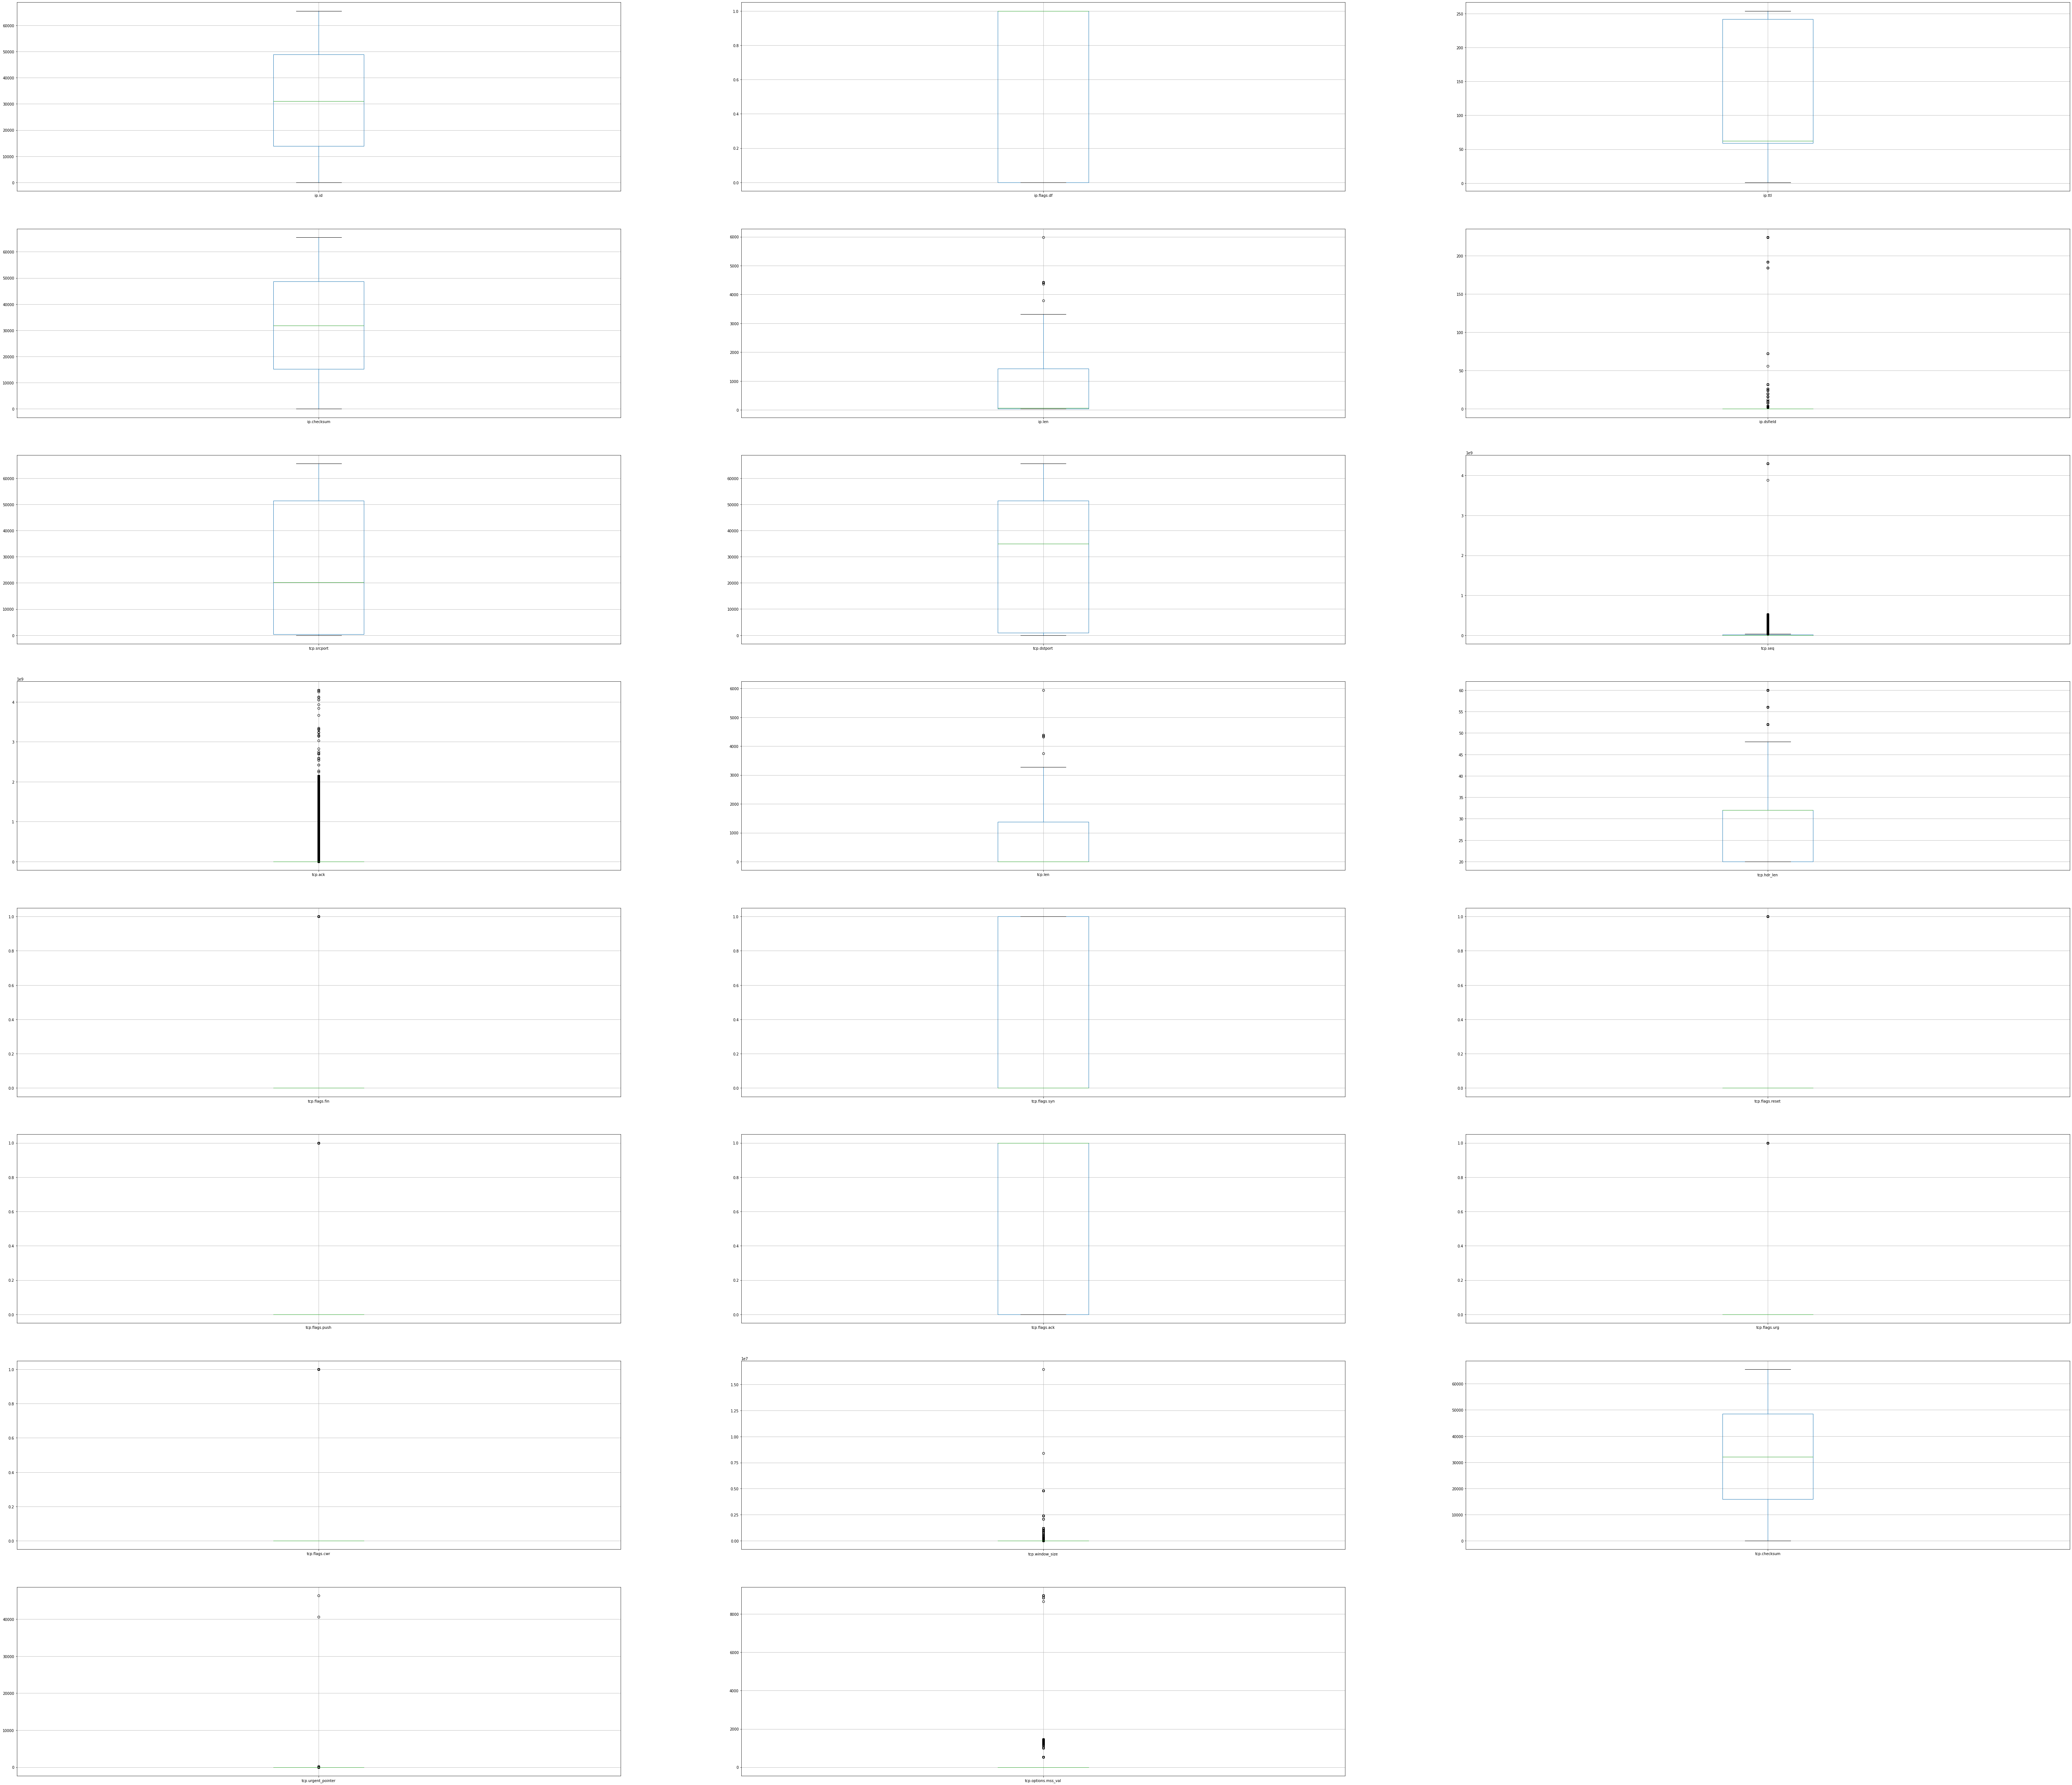

In [23]:
_columns = 3
lines = int(full_data.shape[1]/_columns)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(lines, _columns, i)
        full_data.boxplot([column]);
        i += 1

### Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

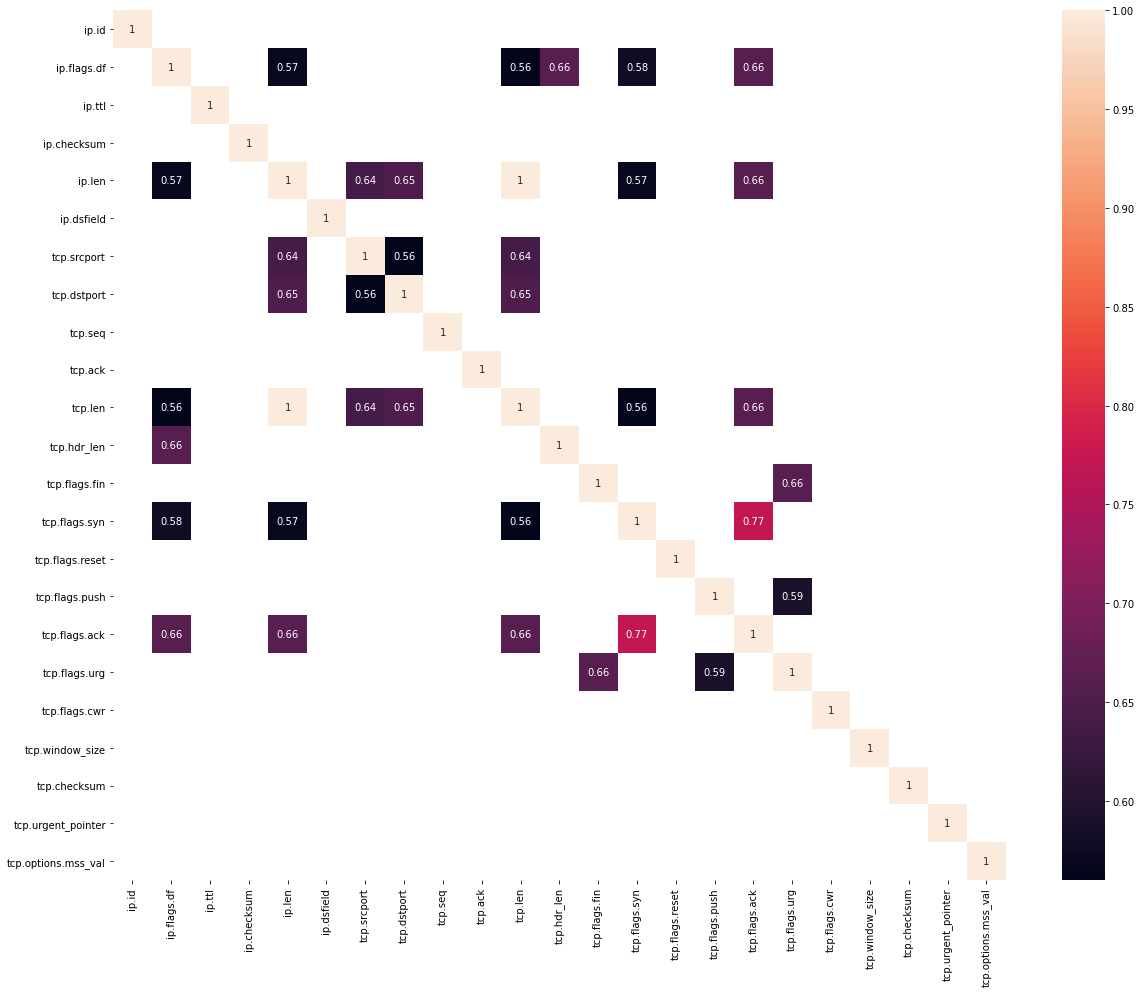

In [25]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Machine Learning - Binary Classification _(attack x bonafide)_

In [26]:
full_data['label'].value_counts()

bonafide                 91386
zmap_tcp_syn              1250
unicornscan_tcp_conn      1026
unicornscan_tcp_syn       1017
unicornscan_tcp_ack       1014
unicornscan_tcp_fin       1014
unicornscan_tcp_fxmas     1014
unicornscan_tcp_xmas      1014
unicornscan_tcp_null      1014
masscan_tcp_syn           1003
nmap_tcp_conn             1002
nmap_tcp_syn              1001
nmap_tcp_fin              1001
nmap_tcp_xmas             1001
nmap_tcp_null             1001
hping_tcp_syn             1001
nmap_tcp_maimon           1000
nmap_tcp_window           1000
nmap_tcp_ack              1000
hping_tcp_null            1000
hping_tcp_xmas            1000
hping_tcp_fin             1000
hping_tcp_ack             1000
Name: label, dtype: int64

In [27]:
full_data.label[full_data.label == "bonafide"] = 0 # convert bonafide label to 0
full_data.label[full_data.label != 0] = 1 # convert attack labels to 1
full_data['label'].value_counts()

0    91386
1    22373
Name: label, dtype: int64

In [28]:
full_data.shape

(113759, 24)

In [29]:
# It is removed ttl because previous attempt shows that it is learning the LAN architecture TTL=62
# (from scan tools TTL=64 minus 2 routers in the infrastructure)

# sequence, checksum and acknowledge features because they are random

# removed source and destination ports to be agnostic regarding the service ports

# removed tcp.options.mss_val because it is dificult to be retrieved as LKM

full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [30]:
full_data

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1      46834          0.0    40.0           0      0.0         20.0   
3       3793          1.0   537.0           8    485.0         32.0   
4          0          1.0    80.0           0      0.0         60.0   
5       8559          1.0    54.0           0      2.0         32.0   
6      54321          0.0    40.0           8      0.0         20.0   
...      ...          ...     ...         ...      ...          ...   
22368  32904          0.0    40.0           0      0.0         20.0   
22369  55978          0.0    40.0           0      0.0         20.0   
22370  32903          0.0    40.0           0      0.0         20.0   
22371   6985          0.0    40.0           0      0.0         20.0   
22372   6984          0.0    40.0           0      0.0         20.0   

       tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1                0.0            1.0              0.0             0.0   
3                0.0            0.0              0.0             1.0   
4                0.0            0.0              0.0             0.0   
5                0.0            0.0              0.0             1.0   
6                0.0            1.0              0.0             0.0   
...              ...            ...              ...             ...   
22368            0.0            1.0              0.0             0.0   
22369            0.0            0.0              1.0             0.0   
22370            0.0            0.0              1.0             0.0   
22371            0.0            1.0              0.0             0.0   
22372            0.0            0.0              1.0             0.0   

       tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1                0.0            0.0            0.0           1024.0   
3                1.0            0.0            0.0            252.0   
4                1.0            0.0            0.0           4677.0   
5                1.0            0.0            0.0            115.0   
6                0.0            0.0            0.0          65535.0   
...              ...            ...            ...              ...   
22368            0.0            0.0            0.0           1024.0   
22369            0.0            0.0            0.0           1200.0   
22370            0.0            0.0            0.0           1200.0   
22371            0.0            0.0            0.0           1024.0   
22372            0.0            0.0            0.0           1200.0   

       tcp.urgent_pointer label  
1                     0.0     0  
3                     0.0     0  
4                     0.0     0  
5                     0.0     0  
6                     0.0     0  
...                   ...   ...  
22368                 0.0     1  
22369                 0.0     1  
22370                 0.0     1  
22371                 0.0     1  
22372                 0.0     1  

[113759 rows x 16 columns]

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    #"MLP" : (MLPClassifier(), {
    #    "hidden_layer_sizes" : (10, 10),
    #}),
    #"XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17, n_jobs=-1), {
        "n_estimators" : [10, 50, 100, 200],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(113759, 15) (113759,)


In [32]:
X.head()

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1  46834          0.0    40.0           0      0.0         20.0   
3   3793          1.0   537.0           8    485.0         32.0   
4      0          1.0    80.0           0      0.0         60.0   
5   8559          1.0    54.0           0      2.0         32.0   
6  54321          0.0    40.0           8      0.0         20.0   

   tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1            0.0            1.0              0.0             0.0   
3            0.0            0.0              0.0             1.0   
4            0.0            0.0              0.0             0.0   
5            0.0            0.0              0.0             1.0   
6            0.0            1.0              0.0             0.0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1            0.0            0.0            0.0           1024.0   
3            1.0            0.0            0.0            252.0   
4            1.0            0.0            0.0           4677.0   
5            1.0            0.0            0.0            115.0   
6            0.0            0.0            0.0          65535.0   

   tcp.urgent_pointer  
1                 0.0  
3                 0.0  
4                 0.0  
5                 0.0  
6                 0.0

In [33]:
X = X.astype(int) 
X.head()

ip.id  ip.flags.df  ip.len  ip.dsfield  tcp.len  tcp.hdr_len  \
1  46834            0      40           0        0           20   
3   3793            1     537           8      485           32   
4      0            1      80           0        0           60   
5   8559            1      54           0        2           32   
6  54321            0      40           8        0           20   

   tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  tcp.flags.push  \
1              0              1                0               0   
3              0              0                0               1   
4              0              0                0               0   
5              0              0                0               1   
6              0              1                0               0   

   tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  tcp.window_size  \
1              0              0              0             1024   
3              1              0              0              252   
4              1              0              0             4677   
5              1              0              0              115   
6              0              0              0            65535   

   tcp.urgent_pointer  
1                   0  
3                   0  
4                   0  
5                   0  
6                   0

## Grid Search

In [34]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB
LR
RF
DT


In [35]:
# f1-scores
pd.DataFrame.from_dict(score)

NB        LR        RF        DT
0  0.547546  0.698852  0.956806  0.962264
1  0.542172  0.716488  0.966806  0.967018
2  0.553234  0.689746  0.956844  0.959773
3  0.553465  0.699286  0.957976  0.958187
4  0.548419  0.704593  0.950283  0.960953
5  0.547078  0.702688  0.958315  0.961073
6  0.547747  0.694942  0.957284  0.958160
7  0.549361  0.702334  0.964073  0.964301
8  0.547590  0.681156  0.952859  0.959771
9  0.539101  0.708625  0.953631  0.960141

## ROC/AUC evaluation

In [36]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = roc_auc_score

results = {}
for algorithm in algorithms.keys():
    results[algorithm] = { 'expected': [], 'predicted': [] }

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])).transpose()[1])

NB
LR
RF
DT


In [37]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    auc = roc_auc_score(results[algorithm]['expected'], results[algorithm]['predicted'])
    print('AUC(%s) = %.4f' % (algorithm, auc))

AUC(NB) = 0.8798
AUC(LR) = 0.9657
AUC(RF) = 0.9962
AUC(DT) = 0.9966


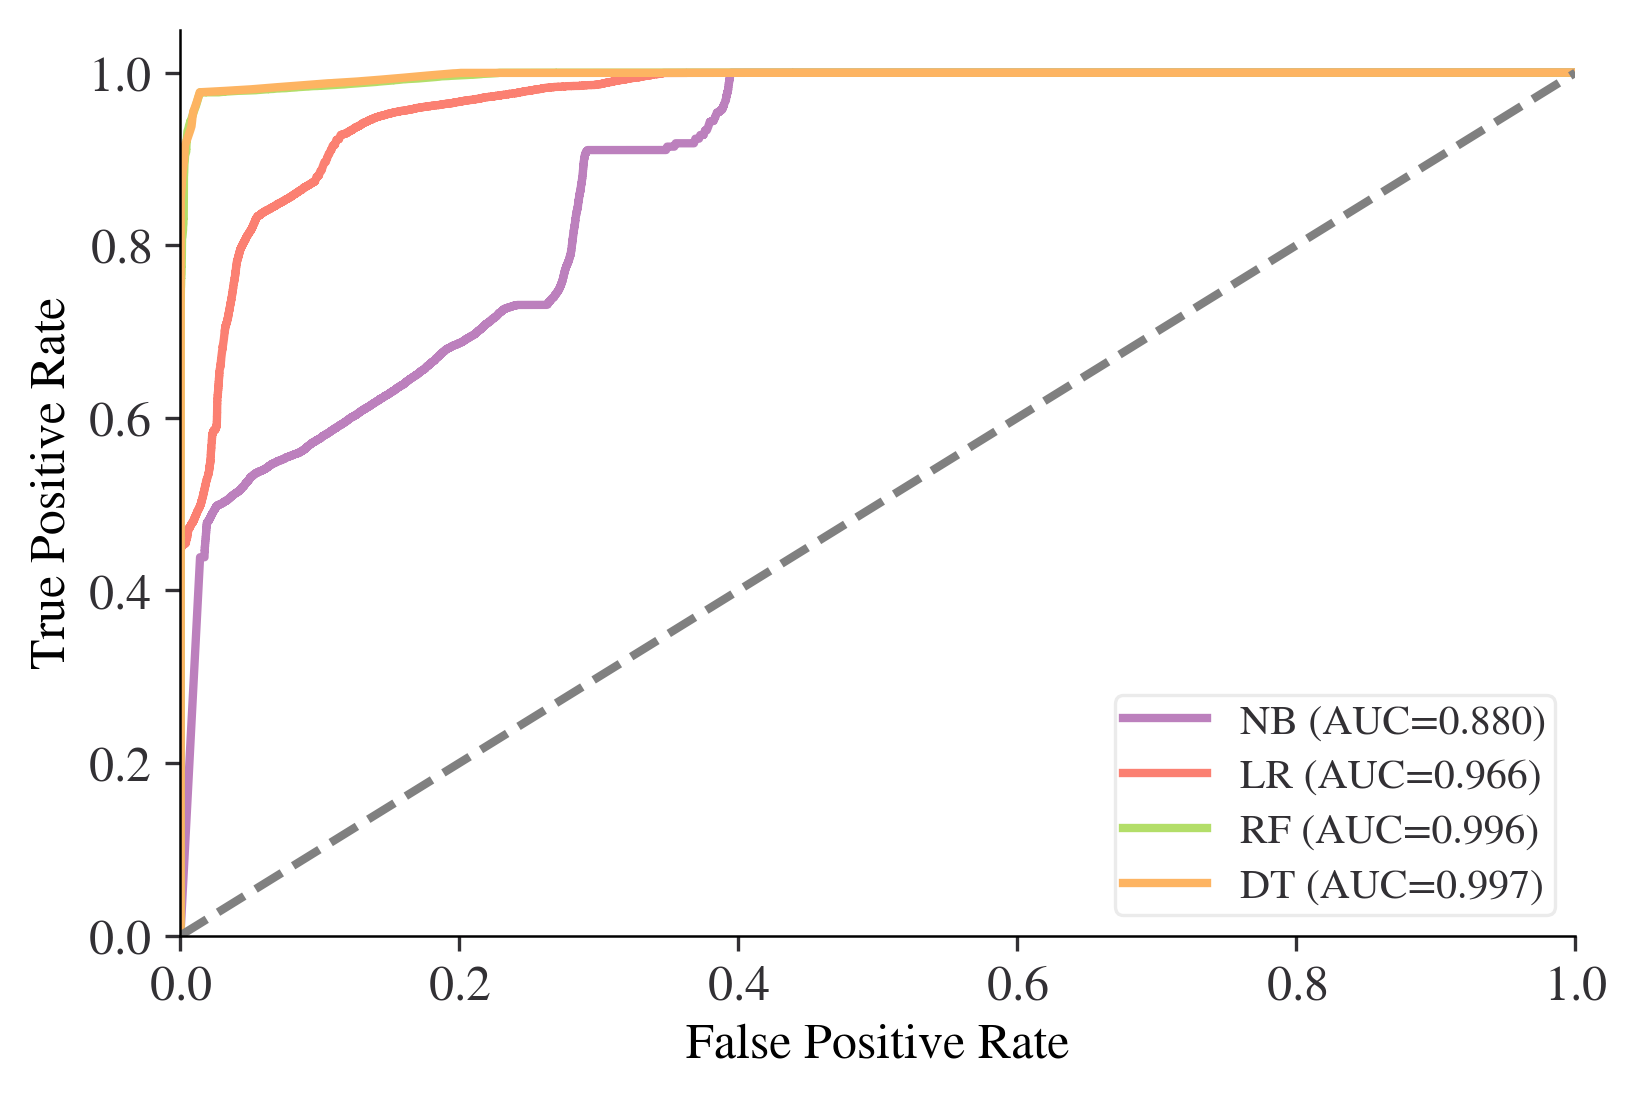

In [38]:
import os
from sklearn.metrics import roc_curve, auc

plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = roc_curve(result['expected'], result['predicted'])
    AUC = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label="{} (AUC={:.3f})".format(model_key, AUC))
    index = index + 1
    # save ROC data
    filename = 'data/LAN_'+model_key+'_ROC_data.csv'
    pd.DataFrame.from_dict(data={ 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds }).to_csv(filename, index=False)
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), dpi=300, bbox_inches="tight")

---

## Results from Grid Search
> For conjunction of parameters, mean and std deviation

In [39]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.675585874529998 0.004653124964520362
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.7806163637310061 0.003125770569594621
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.7862269279723675 0.003329431461578452
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.8926249417587484 0.0002591035620081951
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.9331251458567299 0.0018340837337187928
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.936958583876503 0.003355092276949508
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.959788285007731 0.0018180089418675456
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9814448357530045 0.0005207866684662796
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9816758444097499 0.00040202722756154204
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.9815531378166259 0.000333427034105

In [40]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

In [41]:
plt.style.use('plot_style.txt')

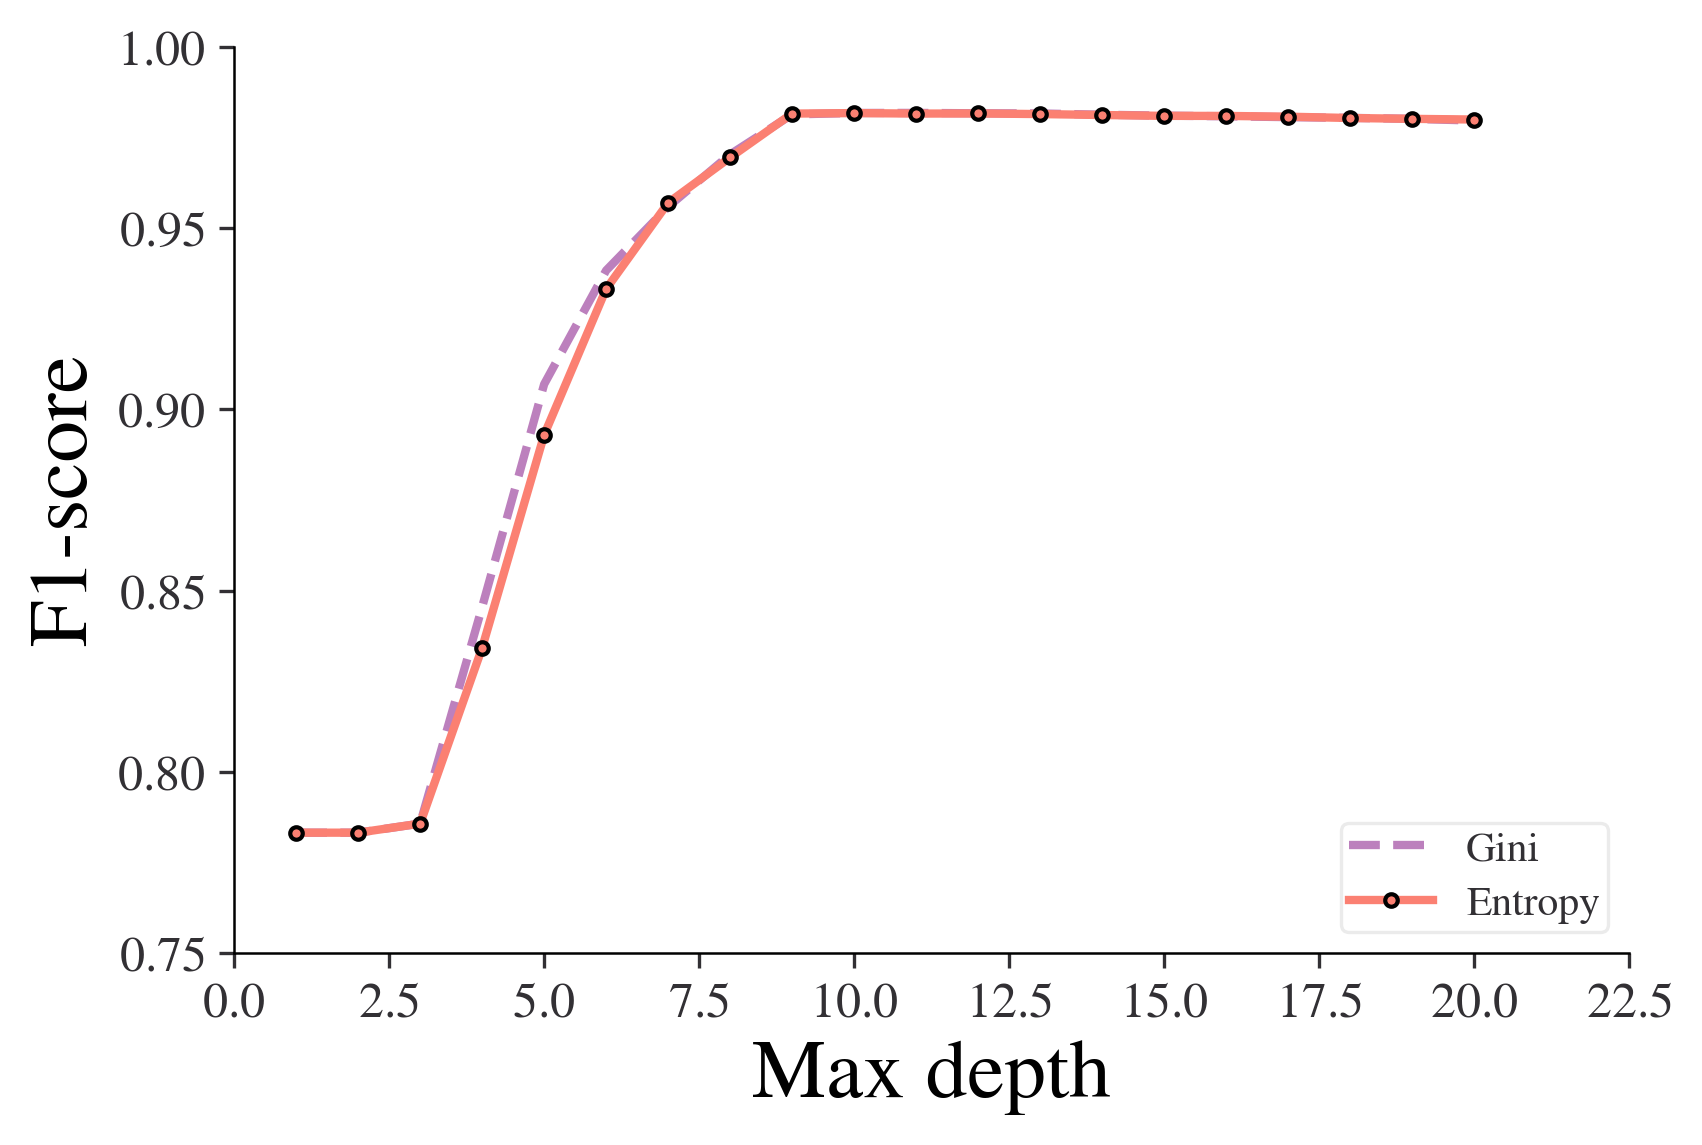

In [42]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

#plt.figure(figsize=(10,8))
#plt.rcParams.update({'font.size': 15})

#plt.title('Performance according to grid-search parameters')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Max depth', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropy')
plt.legend(loc="lower right");
import os
plt.savefig(os.path.join('images/', 'grid_search_dt.pdf'), dpi=300, bbox_inches = "tight")

## ROC Analysis

In [43]:
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced") # {0: 0.01, 1:0.99}

predicted = cross_val_predict(clf, X, y, cv=kf, method='predict_proba')
print(predicted.transpose()[1]) # Probability of the positive class

fpr, tpr, thr = roc_curve(y, predicted.transpose()[1])

[0.10786376 0.         0.         ... 0.94873274 0.10847561 0.94775732]


No handles with labels found to put in legend.


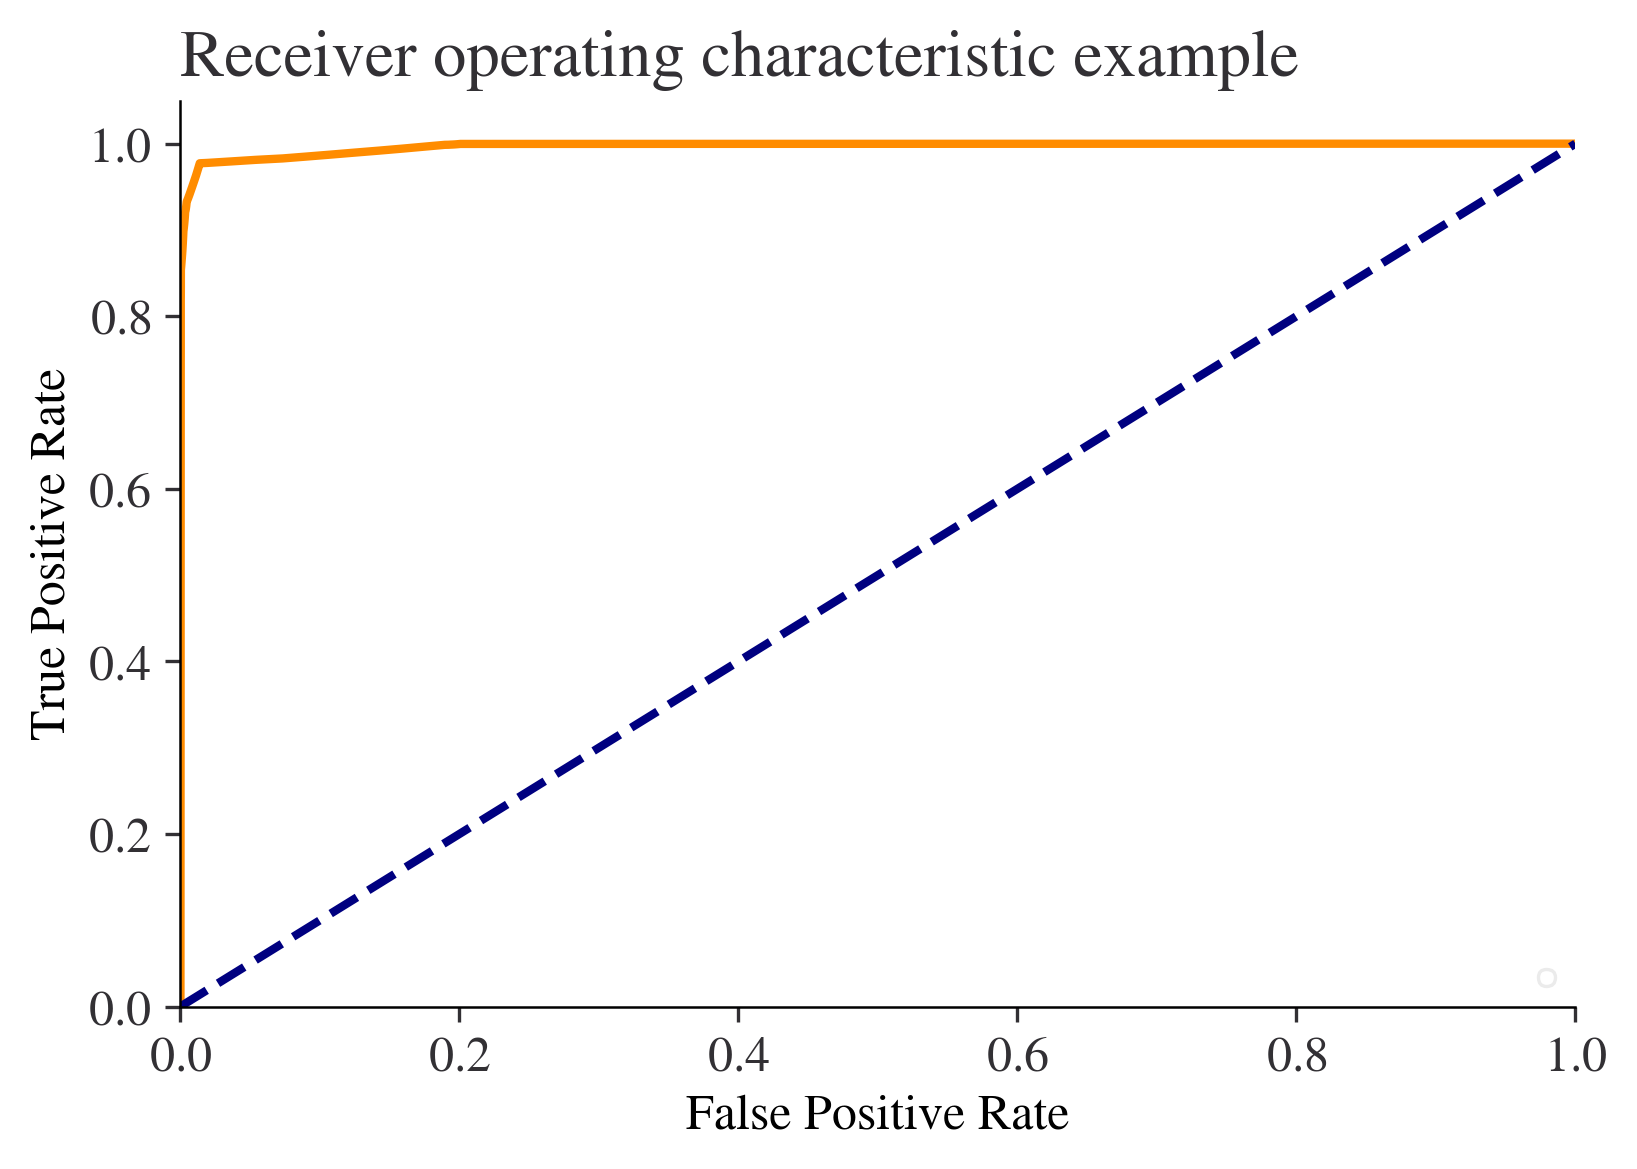

In [44]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [45]:
goal = 0.99
print('Threshold to achieve FPR < %.2f: %.2f' % (1-goal, thr[np.where(fpr < 1 - goal)[0][-1]]))
print('Threshold to achieve TPR > %.2f: %.2f' % (goal, thr[np.where(tpr > goal)[0][0]]))

Threshold to achieve FPR < 0.01: 0.83
Threshold to achieve TPR > 0.99: 0.11


In [46]:
goal = 0.95
print('Threshold to achieve FPR < %.2f: %.2f' % (1-goal, thr[np.where(fpr < 1 - goal)[0][-1]]))
print('Threshold to achieve TPR > %.2f: %.2f' % (goal, thr[np.where(tpr > goal)[0][0]]))

Threshold to achieve FPR < 0.05: 0.11
Threshold to achieve TPR > 0.95: 0.83


In [47]:
goal = 0.90
print('Threshold to achieve FPR < %.2f: %.2f' % (1-goal, thr[np.where(fpr < 1 - goal)[0][-1]]))
print('Threshold to achieve TPR > %.2f: %.2f' % (goal, thr[np.where(tpr > goal)[0][0]]))

Threshold to achieve FPR < 0.10: 0.11
Threshold to achieve TPR > 0.90: 0.95


In [48]:
for thresh in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    print('Using threshold = %.1f, we have FPR=%.2f and TPR=%.2f' % 
          (thresh, fpr[np.where(thr <= thresh)[0][0]], tpr[np.where(thr <= thresh)[0][0]]))

Using threshold = 0.1, we have FPR=0.19 and TPR=1.00
Using threshold = 0.2, we have FPR=0.02 and TPR=0.98
Using threshold = 0.3, we have FPR=0.01 and TPR=0.98
Using threshold = 0.4, we have FPR=0.01 and TPR=0.98
Using threshold = 0.5, we have FPR=0.01 and TPR=0.98
Using threshold = 0.6, we have FPR=0.01 and TPR=0.98
Using threshold = 0.7, we have FPR=0.01 and TPR=0.98
Using threshold = 0.8, we have FPR=0.01 and TPR=0.98
Using threshold = 0.9, we have FPR=0.00 and TPR=0.93


## Feature Importance Evaluation

In [49]:
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='gini', max_depth=11, class_weight="balanced") # {0: 0.01, 1:0.99}

scores = cross_val_score(clf, X, y, cv=kf, scoring='f1') # recall

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.961 (+/- 0.01)


In [50]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=11)

In [53]:
for index, row in relevantes.iterrows():
    print(row.feature_importance, row.feature_name)

0.4450073129819869 ip.len
0.16876804932733747 tcp.window_size
0.11301978713054074 tcp.flags.syn
0.11301094923601575 tcp.hdr_len
0.08414292338611258 tcp.flags.fin
0.0602543021429599 ip.flags.df
0.0108685921014521 ip.id
0.003868975755872529 ip.dsfield
0.0005964380912460675 tcp.flags.ack
0.00038796421953351954 tcp.flags.reset
6.845068144034328e-05 tcp.len
6.254945501984637e-06 tcp.flags.urg
4.9944603935359116e-17 tcp.flags.push


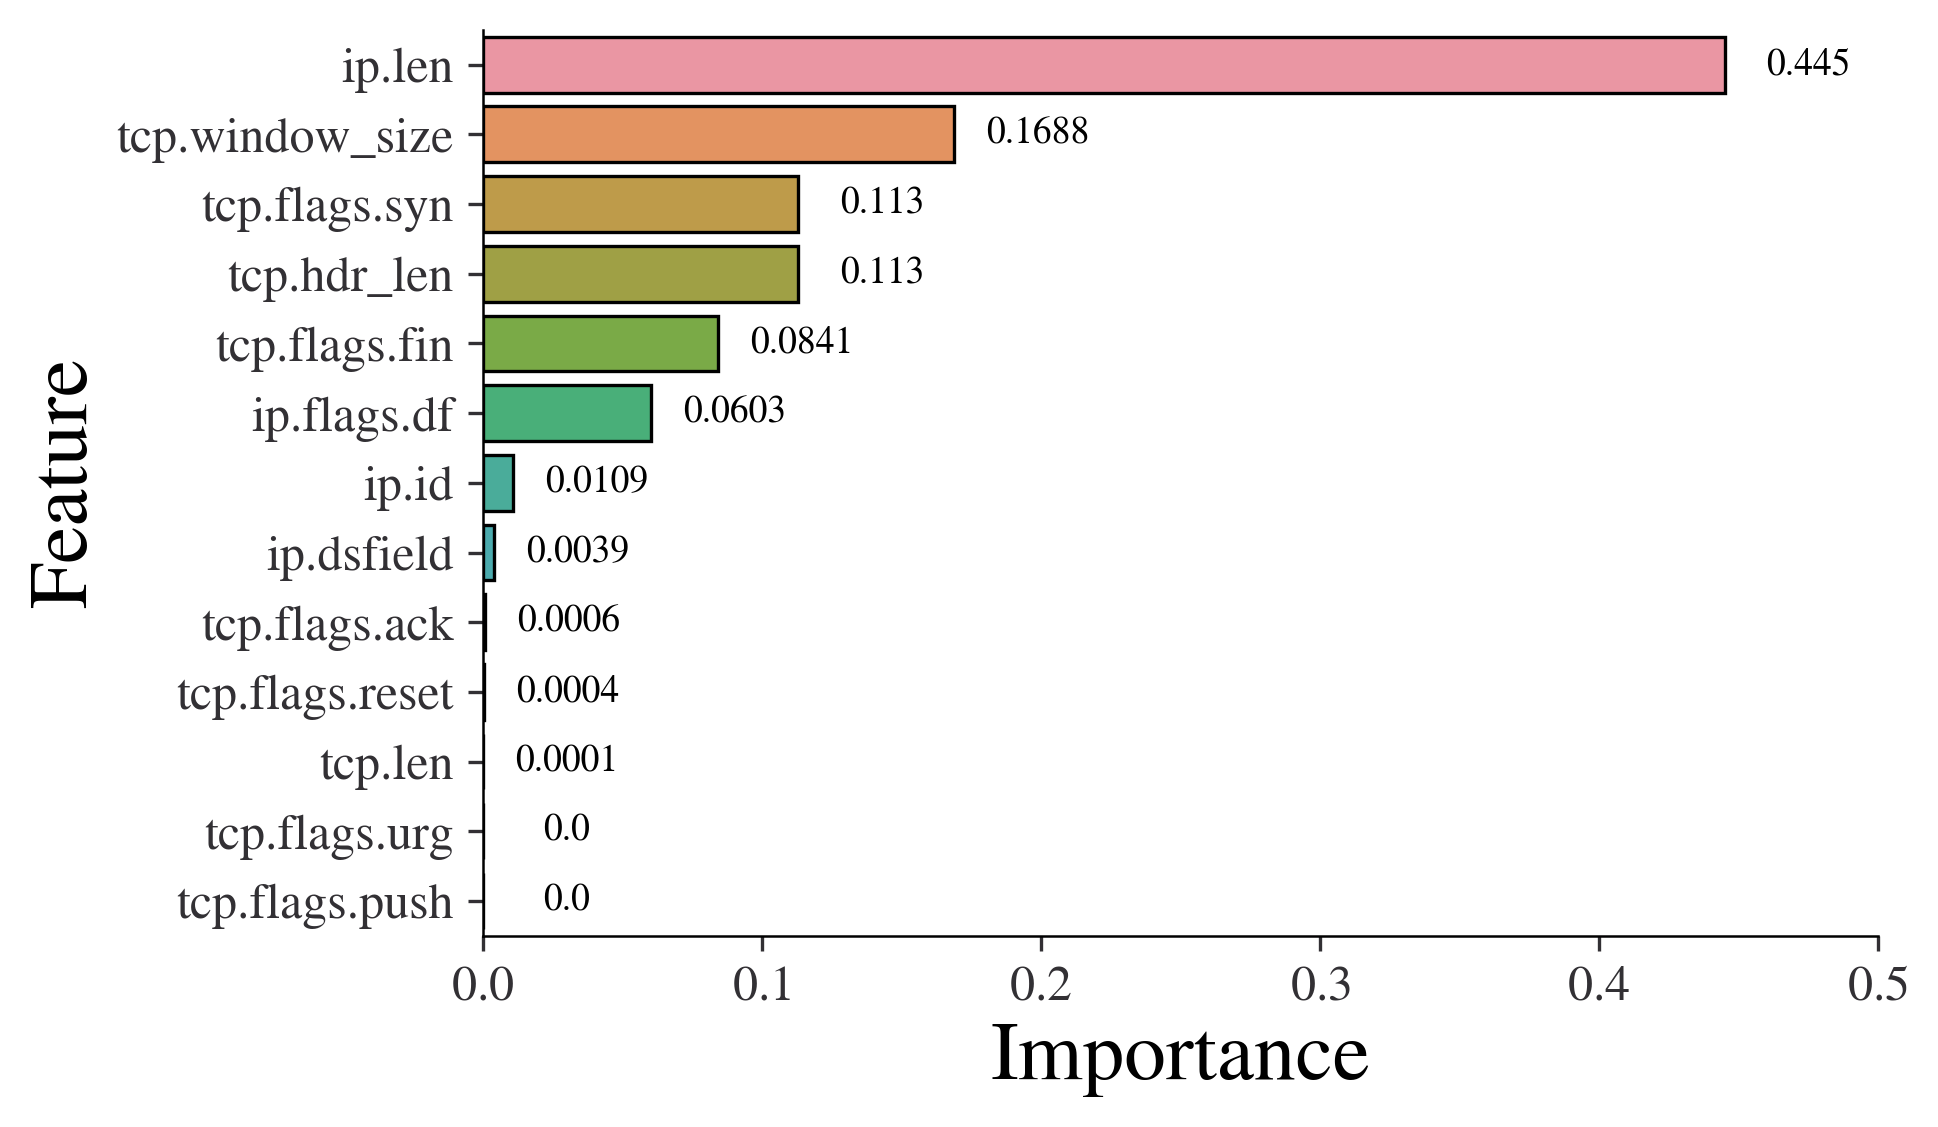

In [52]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

#plt.figure(figsize=(10,8))
g=sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])

plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20);
i=0
for index, row in relevantes.iterrows():
    g.text(row.feature_importance+0.03, i, round(row.feature_importance, 4), color='black', ha="center", va="center", fontsize=9)
    i+=1
plt.savefig(os.path.join('images/', 'feature_importance_dt.pdf'), dpi=300, bbox_inches = "tight")

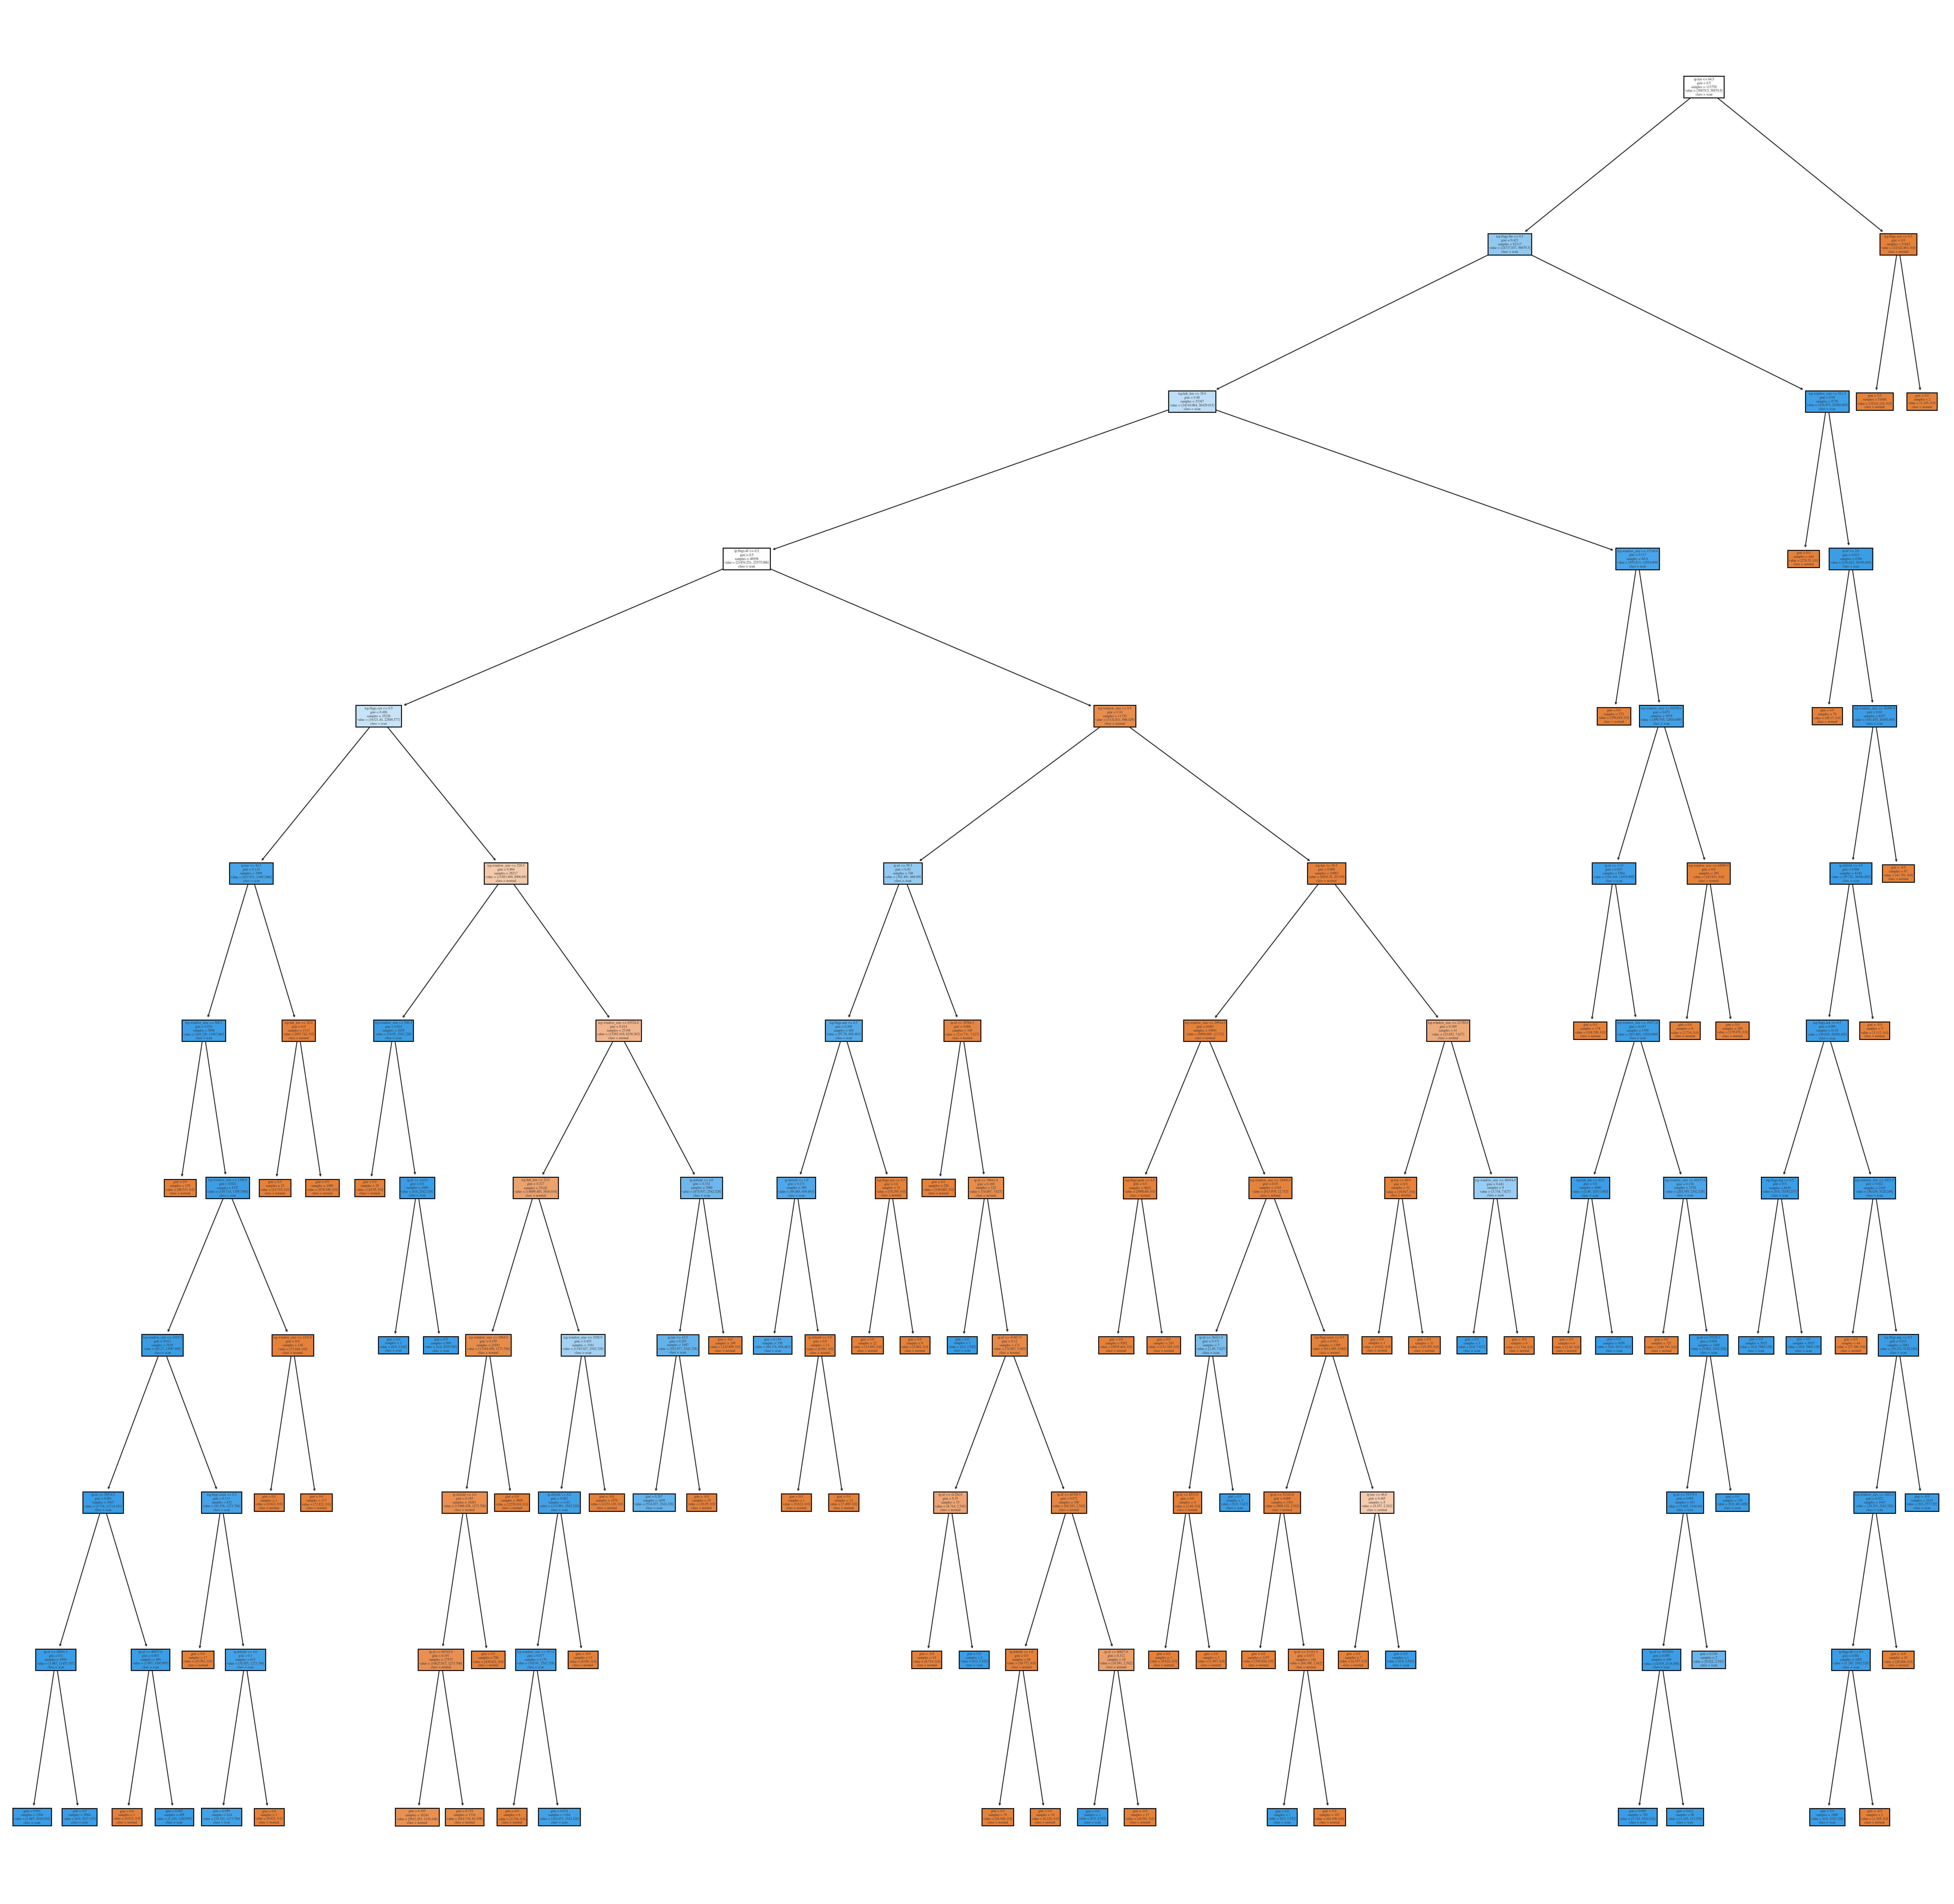

In [54]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [55]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

ModuleNotFoundError: No module named 'graphviz'

# Inference model

In [56]:
import emlearn
cmodel = emlearn.convert(clf)
#cmodel.save(file='../4. [R]ealiz[A]tion/1. Local Area Network/reference/scan.h');

ModuleNotFoundError: No module named 'emlearn'

In [57]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')